##### FINAL VERSION OF SCRIPT -  
Katrina Kalantar
April 2018

Analysis for mBAL microbe study

# Set-up

In [1]:
run_description = 'Trying to get this working with just RNA-input... \nRunning with Meningitis Pathogen List, water correction without scaling  (may over-correct on DNA)'

## Environment Setup

In [2]:
# set the width of the jupyter notebook so we don't waste so much valuable browser real-estate!
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# required libraries
from collections import Counter
import csv
import glob
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from pylab import *
import random
import seaborn as sns
import sklearn
import statistics
import scipy
import scipy.stats
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import roc_curve
import sys, os.path
import warnings; warnings.simplefilter('ignore')
import ecopy

# import microbial analysis and plotting functions 
# developed by me, but moved to external scripts for simplicity in .ipynb
scripts_dir = './scripts/'
sys.path.append(scripts_dir)
import IDseq_pathogen_functions2 
import IDseq_plotting_functions

#https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('fivethirtyeight')   
%matplotlib inline  

## Import Data

### Curated List of Top Respiratory Pathogens (and viruses)
Manually currated from papers and the NCBI taxonomy database

The **list_of_viruses_in_dictionary** contains all microbes which are listed as "Viruses". The **full_respiratory_microbes_list** contains all microbes identified as "likely pathogenic" in the respiratory tract.

In [4]:
# a priori curated list of all viruses
# to obtain this list (of all viruses in the samples), I ran `grep Viruses` 
# in all .csv report files in BM_4
v = open('./reference/viruses_bangldesh_uniq.txt', 'r').readlines()
list_of_viruses_in_dictionary = [i.strip() for i in v]

# Curated list of top respiratory pathogens
resp_mic = open('./reference/pathogens_bangladesh_official.txt', 'r').readlines()
full_respiratory_microbes_list = [i.strip() for i in resp_mic]

### Global Variables

In [5]:
data_directory =  '060618'
output_directory = '070518'  

topX = 25 # because all microbes identified in culture are present among the top 15 microbes


# read in metadata to get RNA and DNA file names
metadata = pd.read_csv(
    './data/' + data_directory +
    '/combined_metadata.tsv',
    sep='\t',
    header=0,
    index_col=0)

# remove rows with null DNA filenames; some samples were missing DNA-seq data
metadata = metadata[metadata['sample_name_DNA']
                    .notnull()]  

# remove rows with null RNA filenames; no RNA-seq files should be missing
metadata = metadata[metadata['sample_name_RNA']
                    .notnull()] 

#print(metadata.head())
true_classification = ''

if('effective_group' in metadata.columns):
    # create the "true_classification" variable from the metadata  
    a = metadata[['sample_name_DNA','effective_group','organism']]
    b = metadata[['sample_name_RNA','effective_group','organism']]
    b.columns = ['sample_name_DNA','effective_group','organism']
    c = pd.concat([a,b])
    c.index = c['sample_name_DNA']
    c.sort_values(by='sample_name_DNA',inplace=True)
    c = c[c['sample_name_DNA'] != 'n/a']
    c = c[['effective_group','organism']]
    true_classification = c

else:
    effective_group = [2 for i in range(len(metadata.index))]
    organism = ['' for i in range(len(metadata.index))]
    c = pd.concat([metadata['sample_name_DNA'],metadata['sample_name_RNA']], axis=1)
    c['effective_group'] = pd.Series(effective_group, index = metadata.index)
    c['organism'] = pd.Series(organism, index = metadata.index)
    true_classification = c

print(true_classification.head())

file_pairs_dict = dict(
    zip(metadata['sample_name_DNA'], metadata['sample_name_RNA']
        ))  #create dictionary mapping RNAfilename with associated DNAfilename

# create a reverse dictionary for file look-up from RNA:DNA later on
file_pairs_dict
file_pairs_dict_rev = {}
for i in file_pairs_dict.keys():
    file_pairs_dict_rev[file_pairs_dict[i]] = i
    

description_file = open('./output/' + output_directory + '/run_description.txt','w')
description_file.write(run_description)
description_file.close()
    

# these sample names were identified by random selection of host RNA-seq data 
# based on RNA-seq batches.
training_sample_names = []
'''
training_sample_names = ["mBAL-212-RNA-TA1-B10.report.csv","mBAL-225-RNA-TA1-B10.report.csv",
                         "mBAL-298-RNA-TA1-B10.report.csv","mBAL-304-RNA-TA1-B10.report.csv",
                         "mBAL-314-RNA-TA1-B10.report.csv","mBAL-315-RNA-TA1-B10.report.csv",
                         "mBAL-335-RNA-TA1-B10.report.csv","mBAL-337-RNA-TA1-B10.report.csv",
                         "mBAL-343-RNA-TA1-B10.report.csv","mBAL-350-RNA-TA1-B10.report.csv",
                         "mBAL-349-RNA-TA1-B10.report.csv","mBAL-273-RNA-TA1-B10.report.csv",
                         "mBAL-331-RNA-TA1-B10.report.csv","mBAL-221-RNA-TA1-B10.report.csv",
                         "mBAL-220-RNA-TA1-B10.report.csv","mBAL-215-RNA-TA1-B10.report.csv",
                         "mBAL-270-RNA-TA1-B10.report.csv","mBAL-241-RNA-TA1-B10.report.csv",
                         "mBAL-211-RNA-TA1-B10.report.csv","mBAL-218-RNA-TA1-B10.report.csv"]
'''

                     effective_group                  organism
sample_name_DNA                                               
CHRF_DNA_0002_C_S4               1.0  Streptococcus pneumoniae
CHRF_DNA_0003_C_S12              1.0  Streptococcus pneumoniae
CHRF_DNA_0004_C_S20              1.0  Streptococcus pneumoniae
CHRF_DNA_0005_C_S28              1.0   Enterobacter hormaechei
CHRF_DNA_0006_C_S36              4.0                       NaN


'\ntraining_sample_names = ["mBAL-212-RNA-TA1-B10.report.csv","mBAL-225-RNA-TA1-B10.report.csv",\n                         "mBAL-298-RNA-TA1-B10.report.csv","mBAL-304-RNA-TA1-B10.report.csv",\n                         "mBAL-314-RNA-TA1-B10.report.csv","mBAL-315-RNA-TA1-B10.report.csv",\n                         "mBAL-335-RNA-TA1-B10.report.csv","mBAL-337-RNA-TA1-B10.report.csv",\n                         "mBAL-343-RNA-TA1-B10.report.csv","mBAL-350-RNA-TA1-B10.report.csv",\n                         "mBAL-349-RNA-TA1-B10.report.csv","mBAL-273-RNA-TA1-B10.report.csv",\n                         "mBAL-331-RNA-TA1-B10.report.csv","mBAL-221-RNA-TA1-B10.report.csv",\n                         "mBAL-220-RNA-TA1-B10.report.csv","mBAL-215-RNA-TA1-B10.report.csv",\n                         "mBAL-270-RNA-TA1-B10.report.csv","mBAL-241-RNA-TA1-B10.report.csv",\n                         "mBAL-211-RNA-TA1-B10.report.csv","mBAL-218-RNA-TA1-B10.report.csv"]\n'

In [6]:
## WATER SUBTRACTION!!!

water_samples_rna = list(metadata[metadata['effective_group']==5]['sample_name_RNA'])
water_samples_dna = list(metadata[metadata['effective_group']==5]['sample_name_DNA'])

# SCALING TO THE PROPORTION MICROBIAL IN REAL SAMPLES
med_DNA = np.median(metadata['nonhost_reads_percent_DNA'])
scale_0033 = med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0033']
scale_0045 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0045']
scale_0057 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0057']
scale_0069 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0069']
scale_0096 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0096']



dna_dir = 'rr007_dna_reports'
rna_dir = 'rapid-response-007_reports'

merge_dna = []
merge_rna = []

for i in water_samples_dna:
    print(i)
    dna_file = 'data/' + data_directory + '/' + dna_dir + '/' + i.lower() + '.csv'
    rna_file = 'data/' + data_directory + '/' + rna_dir + '/' + file_pairs_dict[i].lower() + '.csv'
    df_dna = pd.read_csv(dna_file, error_bad_lines=False)
    df_dna = df_dna[df_dna['tax_level'] == 2]
    scaled_df_dna = None
    '''
    if('0033' in i):
        df_dna['NT_rpm'] = df_dna['NT_rpm'] * scale_0033
        scaled_df_dna = df_dna[df_dna['tax_id'] > 0][['NT_rpm','genus_taxid']] 
    elif('0045' in i):
        df_dna['NT_rpm'] = df_dna['NT_rpm'] * scale_0045
        scaled_df_dna = df_dna[df_dna['tax_id'] > 0][['NT_rpm','genus_taxid']] 
    elif('0057' in i):
        df_dna['NT_rpm'] = df_dna['NT_rpm'] * scale_0057
        scaled_df_dna = df_dna[df_dna['tax_id'] > 0][['NT_rpm','genus_taxid']] 
    elif('0069' in i):
        df_dna['NT_rpm'] = df_dna['NT_rpm'] * scale_0069
        scaled_df_dna = df_dna[df_dna['tax_id'] > 0][['NT_rpm','genus_taxid']] 
    elif('0096' in i):
        df_dna['NT_rpm'] = df_dna['NT_rpm'] * scale_0096
        scaled_df_dna = df_dna[df_dna['tax_id'] > 0][['NT_rpm','genus_taxid']]  
    merge_dna.append(scaled_df_dna)
    '''

        
        
    merge_dna.append(df_dna)
    df_rna = pd.read_csv(rna_file, error_bad_lines=False)
    df_rna = df_rna[df_rna['tax_level'] == 2]
    merge_rna.append(df_rna[df_rna['tax_id'] > 0][['NT_rpm','genus_taxid']])

    print(df_rna[df_rna['genus_taxid'] == 11019]['NT_rpm'])

def compute_water_subtraction(merge_samples): 
    '''
    Take all the water files, merge the NT rpm and compute the mean rpm for each genus
    '''
    df = merge_samples[0]
    for df_ in merge_samples[1:]:
        df = df.merge(df_,how='outer',on='genus_taxid') 
    df.index = df['genus_taxid']
    df = df.drop('genus_taxid', axis=1)
    df = df.fillna(0)
    return(df.mean(axis=1))

dna_genus_water_subtraction = compute_water_subtraction(merge_dna)
rna_genus_water_subtraction = compute_water_subtraction(merge_rna)

#dna_genus_water_subtraction = None #compute_water_subtraction(merge_dna)
#rna_genus_water_subtraction = None #compute_water_subtraction(merge_rna)


dna_genus_water_subtraction.to_csv('./output/' + output_directory + '/water_correction_genus_DNA.csv')
rna_genus_water_subtraction.to_csv('./output/' + output_directory + '/water_correction_genus_RNA.csv')




CHRF_DNA_0033_C_S62
Series([], Name: NT_rpm, dtype: float64)
CHRF_DNA_0045_C_S63
Series([], Name: NT_rpm, dtype: float64)
CHRF_DNA_0057_C_S64
Series([], Name: NT_rpm, dtype: float64)
CHRF_DNA_0069_C_S65
Series([], Name: NT_rpm, dtype: float64)
CHRF_DNA_0096_C_S91
152    0.2
Name: NT_rpm, dtype: float64


In [7]:
#print(dna_genus_water_subtraction)
#print(dna_genus_water_subtraction.to_frame(name='DNA'))
df = dna_genus_water_subtraction.to_frame(name='DNA').join(rna_genus_water_subtraction.to_frame(name='RNA'),how='outer')
#print(df.sort_values(by='DNA', ascending = False))
print(1763 in df.index)

# where did enterovirus go???
print(12059 in df.index)
print(138948 in df.index)
print(138949 in df.index)
#plt.scatter(rna_genus_water_subtraction, dna_genus_water_subtraction)

True
False
False
False


In [8]:
med_DNA = np.median(metadata['nonhost_reads_percent_DNA'])
scale_0033 = med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0033']
scale_0045 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0045']
scale_0057 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0057']
scale_0069 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0069']
scale_0096 =  med_DNA/metadata['nonhost_reads_percent_DNA']['CHRF_0096']
print(scale_0033)
print("--")

print(med_DNA)
print(metadata['nonhost_reads_percent_DNA']['CHRF_0033'])
print(metadata['nonhost_reads_percent_DNA']['CHRF_0045'])
print(metadata['nonhost_reads_percent_DNA']['CHRF_0057'])
print(metadata['nonhost_reads_percent_DNA']['CHRF_0069'])
print(metadata['nonhost_reads_percent_DNA']['CHRF_0096'])

print(np.median(metadata['nonhost_reads_percent_RNA']))
print(metadata['nonhost_reads_percent_RNA']['CHRF_0033'])
print(metadata['nonhost_reads_percent_RNA']['CHRF_0045'])
print(metadata['nonhost_reads_percent_RNA']['CHRF_0057'])
print(metadata['nonhost_reads_percent_RNA']['CHRF_0069'])
print(metadata['nonhost_reads_percent_RNA']['CHRF_0096'])

0.07023533715400561
--
0.5760000000000001
8.201
5.572
10.561
7.437
8.931000000000001
0.16
0.134
0.16
0.19
0.13
0.141


In [9]:
# write the microbes used for this particular analysis to the output directory
open('./output/' + output_directory + '/USED.viruses.txt', 'w').write(
    '\n'.join(list_of_viruses_in_dictionary));
open('./output/' + output_directory + '/USED.known_respiratory_pathogens.txt',
     'w').write('\n'.join(full_respiratory_microbes_list));

# Run Analysis

Run the main functions to generate scores required for all further plotting steps.

In [10]:
# create the output file that will containg the top 20 microbes for each sample 
# with the caveat that all microbes must be present on both RNA-seq and 
# DNA-seq (with the exception of RNA viruses)
f = open('./output/' + output_directory + '/TableS4.csv', 'w')
f.close()

f = open('./output/' + output_directory + '/TableS4_lowcount.csv', 'w')
f.close()

# run the main function to load microbial data into the data structure for downstream analysis
main_output = IDseq_pathogen_functions2.main('data/' + data_directory, 
                                      'rr007_dna_reports', 'rapid-response-007_reports',
                                      file_pairs_dict, output_directory,
                                      metadata, subtract_dna = dna_genus_water_subtraction, 
                                            subtract_rna = rna_genus_water_subtraction, expect_DNA=False) 
bacterial = main_output[0]
viral = main_output[1]
full = main_output[2]

list_of_files = list(
    bacterial.keys())  # create list of RNA files for accessing the outputs




./data/060618/rapid-response-007_reports/chrf_rna_0002_s2.csv
./data/060618/rr007_dna_reports/chrf_dna_0002_c_s4.csv
Input counts:(4037, 26)
After removing non-specific counts:(3493, 26)
After removing z < 1 counts:(310, 26)
RNA shape in calculate_scores:
(235, 29)
RNA HEAD
(4, 8)
  category_name  genus_taxid   NT_rpm  NT_zscore  genus_NT_rpm  \
0      Bacteria         1301  16162.5       36.4       19144.3   
1      Bacteria         1301      4.7        1.6       19144.3   
3      Bacteria         1301      4.8        2.6       19144.3   
8      Bacteria         1301      0.9        1.9       19144.3   

   genus_NT_zscore                         name  NR_rpm  
0             12.7     Streptococcus pneumoniae  9375.1  
1             12.7  Streptococcus parasanguinis     6.8  
3             12.7      Streptococcus anginosus    50.6  
8             12.7          Streptococcus iniae     0.1  
RNA HEAD2
(1, 8)
  category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \





./data/060618/rapid-response-007_reports/chrf_rna_0005_s5.csv
./data/060618/rr007_dna_reports/chrf_dna_0005_c_s28.csv
Input counts:(4073, 26)
After removing non-specific counts:(3599, 26)
After removing z < 1 counts:(412, 26)
RNA shape in calculate_scores:
(302, 29)
RNA HEAD
(20, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
3       Bacteria          547    38.6       99.0         465.9   
4       Bacteria          547    99.8       13.9         465.9   
6       Bacteria          547     1.8        1.2         465.9   
30      Bacteria          544    36.4        8.3          40.1   
44      Bacteria         -200     0.1      100.0           NaN   

    genus_NT_zscore                                               name  NR_rpm  
3               6.0                        Enterobacter xiangfangensis     0.3  
4               6.0                            Enterobacter hormaechei    11.2  
6               6.0  Enterobacter cloacae complex 'Hoffmann cluster...   

Input counts:(6102, 26)
After removing non-specific counts:(5359, 26)
After removing z < 1 counts:(867, 26)
RNA shape in calculate_scores:
(605, 29)
RNA HEAD
(37, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
7         Viruses       110456     3.9       99.0           4.2   
36       Bacteria          551     0.2        2.1           NaN   
57        Viruses   -200010699     0.1      100.0           NaN   
158      Bacteria         -200     0.1        3.8           NaN   
160      Bacteria         -200     0.2       15.3           NaN   

     genus_NT_zscore                             name  NR_rpm  
7               99.0             Escherichia virus T7     1.6  
36               NaN                Erwinia amylovora    11.1  
57               NaN  Mycobacterium phage Carcharodon     0.1  
158              NaN      uncultured bacterium CSL142     0.4  
160              NaN         uncultured bacterium 5E7     0.2  
RNA HEAD2
(34, 8)
    category_name  genus_taxi

Input counts:(2766, 26)
After removing non-specific counts:(2423, 26)
After removing z < 1 counts:(114, 26)
RNA shape in calculate_scores:
(79, 29)
RNA HEAD
(4, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
2        Viruses        39744     0.7       21.5           0.7   
28      Bacteria         1279     0.1        2.0           NaN   
40      Bacteria        53457     0.4      100.0           NaN   
56       Viruses       325455     0.1        2.0           NaN   

    genus_NT_zscore                     name  NR_rpm  
2              21.5        Mumps rubulavirus     0.6  
28              NaN  Staphylococcus arlettae     0.1  
40              NaN       Janibacter indicus     0.2  
56              NaN    Gammapapillomavirus 7     0.1  
RNA HEAD2
(4, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
2        Viruses        39744         0.7           21.5               0.7   
28      Bacteria         1279         0.1            2.0 


./data/060618/rapid-response-007_reports/chrf_rna_0016_s16.csv
./data/060618/rr007_dna_reports/chrf_dna_0016_c_s21.csv
Input counts:(5229, 26)
After removing non-specific counts:(4565, 26)
After removing z < 1 counts:(919, 26)
RNA shape in calculate_scores:
(634, 29)
RNA HEAD
(44, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
20      Bacteria       146935     0.1       10.7           3.1   
39      Bacteria        46255     0.9        4.8          30.2   
64      Bacteria         1060    22.3       17.0          41.1   
65      Bacteria         1060     8.9       13.0          41.1   
70      Bacteria      1434002     0.1       12.9           0.7   

    genus_NT_zscore                       name  NR_rpm  
20             99.0       Azovibrio restrictus     4.0  
39              3.1        Weissella hellenica     0.3  
64              5.6    Rhodobacter sp. LPB0142     0.1  
65              5.6     Rhodobacter capsulatus     0.7  
70             65.0  Falsirhodob




./data/060618/rapid-response-007_reports/chrf_rna_0019_s19.csv
./data/060618/rr007_dna_reports/chrf_dna_0019_c_s45.csv
Input counts:(3762, 26)
After removing non-specific counts:(3279, 26)
After removing z < 1 counts:(664, 26)
RNA shape in calculate_scores:
(469, 29)
RNA HEAD
(52, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
7       Bacteria   -200000543     0.8        1.2           NaN   
16      Bacteria          613    37.8       16.7         107.6   
25      Bacteria      1649453     6.5       77.7           6.5   
61      Bacteria         1372     9.0        8.6          52.2   
69      Bacteria      1649490     4.6       36.1           4.6   

    genus_NT_zscore                        name  NR_rpm  
7               NaN      Plautia stali symbiont     0.4  
16             10.6       Serratia liquefaciens     0.6  
25             77.7               Gimesia maris     0.8  
61              3.1     Planococcus antarcticus     0.2  
69             36.1  Rubi




./data/060618/rapid-response-007_reports/chrf_rna_0022_s22.csv
./data/060618/rr007_dna_reports/chrf_dna_0022_c_s69.csv
Input counts:(6881, 26)
After removing non-specific counts:(6077, 26)
After removing z < 1 counts:(674, 26)
RNA shape in calculate_scores:
(500, 29)
RNA HEAD
(17, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
10        Viruses   -200010662     0.2      100.0           NaN   
12       Bacteria        76890     8.2        7.4          10.2   
189      Bacteria          662     0.2        4.9           3.5   
191      Bacteria          662     0.1        7.4           3.5   
194      Bacteria          662     0.1        1.3           3.5   

     genus_NT_zscore                          name  NR_rpm  
10               NaN  Erwinia phage vB_EamM_Huxley     0.3  
12               9.0     Asticcacaulis excentricus     1.2  
189              2.1             Vibrio vulnificus     0.3  
191              2.1           Vibrio crassostreae     0.5  
194 




./data/060618/rapid-response-007_reports/chrf_rna_0026_s26.csv
./data/060618/rr007_dna_reports/chrf_dna_0026_c_s6.csv
Input counts:(1791, 26)
After removing non-specific counts:(1519, 26)
After removing z < 1 counts:(79, 26)
RNA shape in calculate_scores:
(59, 29)
RNA HEAD
(0, 8)
Empty DataFrame
Columns: [category_name, genus_taxid, NT_rpm, NT_zscore, genus_NT_rpm, genus_NT_zscore, name, NR_rpm]
Index: []
RNA HEAD2
(0, 8)
Empty DataFrame
Columns: [category_name, genus_taxid, NT_rpm RNA, NT_zscore RNA, genus_NT_rpm RNA, genus_NT_zscore RNA, name, NR_rpm RNA]
Index: []
Empty DataFrame
Columns: [category_name, NT_rpm RNA, NT_zscore RNA, genus_NT_rpm RNA, genus_NT_zscore RNA, name, NR_rpm RNA, genus_taxid]
Index: []



./data/060618/rapid-response-007_reports/chrf_rna_0027_s27.csv
./data/060618/rr007_dna_reports/chrf_dna_0027_c_s14.csv
Input counts:(3932, 26)
After removing non-specific counts:(3456, 26)
After removing z < 1 counts:(268, 26)
RNA shape in calculate_scores:
(212, 29)
RNA 




./data/060618/rapid-response-007_reports/chrf_rna_0030_s30.csv
./data/060618/rr007_dna_reports/chrf_dna_0030_c_s38.csv
Input counts:(3358, 26)
After removing non-specific counts:(2892, 26)
After removing z < 1 counts:(390, 26)
RNA shape in calculate_scores:
(286, 29)
RNA HEAD
(5, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
155       Viruses        10912     0.1       39.6           0.1   
163      Bacteria         2147     0.5       39.2           0.5   
170      Bacteria         1763     0.3        2.5           NaN   
211      Bacteria          586     0.3        4.1           0.3   
214      Bacteria          662     0.1      100.0           NaN   

     genus_NT_zscore                       name  NR_rpm  
155             16.6                Rotavirus A     0.1  
163              4.7     Acholeplasma laidlawii     0.3  
170              NaN  Mycobacterium mucogenicum     1.0  
211              1.5       Providencia stuartii     1.5  
214              NaN




./data/060618/rapid-response-007_reports/chrf_rna_0033_s33.csv
./data/060618/rr007_dna_reports/chrf_dna_0033_c_s62.csv
Input counts:(2794, 26)
After removing non-specific counts:(2404, 26)
After removing z < 1 counts:(366, 26)
RNA shape in calculate_scores:
(270, 29)
RNA HEAD
(13, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
4         Viruses        12320     0.2      100.0           0.2   
29       Bacteria         -200     0.1        2.0           NaN   
156      Bacteria          590     6.7        1.3           6.7   
163      Bacteria          662     0.4      100.0           NaN   
164      Bacteria          662     0.1       40.0           NaN   

     genus_NT_zscore                             name  NR_rpm  
4              100.0             Alfalfa mosaic virus     0.2  
29               NaN  uncultured bacterium 413004-H17     0.2  
156              1.3              Salmonella enterica    35.3  
163              NaN                 Vibrio sp. RV-16

0                  NaN  Torque teno midi virus         0.2  



./data/060618/rapid-response-007_reports/chrf_rna_0038_s38.csv
./data/060618/rr007_dna_reports/chrf_dna_0038_c_s7.csv
Input counts:(4069, 26)
After removing non-specific counts:(3532, 26)
After removing z < 1 counts:(315, 26)
RNA shape in calculate_scores:
(221, 29)
RNA HEAD
(1, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
90      Bacteria         1763     2.1        2.2           NaN   

    genus_NT_zscore                          name  NR_rpm  
90              NaN  uncultured Mycobacterium sp.     0.2  
RNA HEAD2
(1, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
90      Bacteria         1763         2.1            2.2               NaN   

    genus_NT_zscore RNA                          name  NR_rpm RNA  
90                  NaN  uncultured Mycobacterium sp.         0.2  
  category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0      Bacter

Input counts:(3681, 26)
After removing non-specific counts:(3211, 26)
After removing z < 1 counts:(315, 26)
RNA shape in calculate_scores:
(240, 29)
RNA HEAD
(12, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
90       Bacteria         -200     0.1        4.2           NaN   
126      Bacteria         2147     0.7       52.0           0.7   
128       Viruses       186765     0.6      100.0           NaN   
131      Bacteria          590     9.7        2.0           9.8   
162      Bacteria        53457     1.0      100.0           NaN   

     genus_NT_zscore                             name  NR_rpm  
90               NaN  uncultured bacterium A1Q1_fos_4     0.2  
126              6.4           Acholeplasma laidlawii     0.5  
128              NaN       Enterobacteria phage phi80     0.1  
131              2.0              Salmonella enterica    41.7  
162              NaN               Janibacter indicus     0.2  
RNA HEAD2
(9, 8)
    category_name  genus_taxid

Input counts:(3121, 26)
After removing non-specific counts:(2652, 26)
After removing z < 1 counts:(476, 26)
RNA shape in calculate_scores:
(340, 29)
RNA HEAD
(18, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
43       Bacteria         -200     0.9       63.3           NaN   
48        Viruses         -200     0.2      100.0           NaN   
72       Bacteria         -200     0.1       32.0           NaN   
111      Bacteria         -200     0.5        6.3           NaN   
120      Bacteria         -200     0.2        2.1           NaN   

     genus_NT_zscore                                           name  NR_rpm  
43               NaN  uncultured Chloroflexi bacterium HF0200_09I09     0.7  
48               NaN                    Hubei partiti-like virus 18     0.2  
72               NaN  uncultured gamma proteobacterium HF0010_05D02     3.0  
111              NaN                       uncultured bacterium 164     0.2  
120              NaN                     

(4, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
102       Viruses       110456     0.4       13.0           0.4   
108      Bacteria          581     0.6        2.7           0.7   
110      Bacteria         2147     0.3       21.0           0.3   
122      Bacteria          662     0.2        2.0           NaN   

     genus_NT_zscore                    name  NR_rpm  
102             11.8    Escherichia virus T7     0.1  
108              2.9     Morganella morganii     0.1  
110              2.4  Acholeplasma laidlawii     0.2  
122              NaN    Vibrio alginolyticus     0.1  
RNA HEAD2
(4, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
102       Viruses       110456         0.4           13.0               0.4   
108      Bacteria          581         0.6            2.7               0.7   
110      Bacteria         2147         0.3           21.0               0.3   
122      Bacteria          662         0.2       

9         2.3  



./data/060618/rapid-response-007_reports/chrf_rna_0053_s53.csv
./data/060618/rr007_dna_reports/chrf_dna_0053_c_s32.csv
Input counts:(4242, 26)
After removing non-specific counts:(3796, 26)
After removing z < 1 counts:(347, 26)
RNA shape in calculate_scores:
(271, 29)
RNA HEAD
(18, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
10       Bacteria         1350     0.5        9.0          39.1   
11       Bacteria         1350     0.3        1.7          39.1   
137      Bacteria        57493    76.2        1.1           NaN   
143      Bacteria        40222     0.3        4.0           0.9   
144      Bacteria        40222     0.4        2.9           0.9   

     genus_NT_zscore                                   name  NR_rpm  
10               1.8                  Enterococcus italicus     0.4  
11               1.8                   Enterococcus mundtii     0.9  
137              NaN                      Kocuria palustris    33.5  
143          




./data/060618/rapid-response-007_reports/chrf_rna_0056_s56.csv
./data/060618/rr007_dna_reports/chrf_dna_0056_c_s56.csv
Input counts:(5218, 26)
After removing non-specific counts:(4645, 26)
After removing z < 1 counts:(449, 26)
RNA shape in calculate_scores:
(339, 29)
RNA HEAD
(28, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
7        Viruses       110456     1.0       34.3           1.8   
10      Bacteria   -200076892     0.2        1.2           NaN   
19       Viruses        12320     0.1      100.0           0.1   
21       Viruses        10912     0.2       83.0           0.2   
51      Bacteria         -200     0.2      100.0           NaN   

    genus_NT_zscore                                   name  NR_rpm  
7              56.5                   Escherichia virus T7     0.2  
10              NaN  Caulobacteraceae bacterium OTSz_A_272     0.1  
19            100.0                   Alfalfa mosaic virus     0.1  
21             34.9                    

RNA HEAD
(34, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0      Bacteria        40323  7726.2       23.1        9808.3   
1      Bacteria        40323   947.0       21.2        9808.3   
2      Bacteria        40323     0.1      100.0        9808.3   
3      Bacteria        40323    15.2       23.3        9808.3   
7      Bacteria        40323     1.1       71.8        9808.3   

   genus_NT_zscore                             name  NR_rpm  
0             25.1     Stenotrophomonas maltophilia  2581.5  
1             25.1       Stenotrophomonas sp. WZN-1     4.6  
2             25.1         Stenotrophomonas pavanii    24.5  
3             25.1  uncultured Stenotrophomonas sp.     2.5  
7             25.1             Stenotrophomonas sp.     0.1  
RNA HEAD2
(15, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0        Bacteria        40323      7726.2           23.1            9808.3   
180      Bacteria   -200032033         2.9  

Input counts:(3694, 26)
After removing non-specific counts:(3272, 26)
After removing z < 1 counts:(139, 26)
RNA shape in calculate_scores:
(114, 29)
RNA HEAD
(11, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0      Bacteria          482  3177.4       99.0        3424.4   
1      Bacteria          482    36.9       41.7        3424.4   
2      Bacteria          482    57.6       59.5        3424.4   
3      Bacteria          482     1.2       99.0        3424.4   
4      Bacteria          482     1.5        2.2        3424.4   

   genus_NT_zscore                     name  NR_rpm  
0             99.0   Neisseria meningitidis  1483.8  
1             99.0    Neisseria gonorrhoeae    63.9  
2             99.0      Neisseria lactamica    31.0  
3             99.0  Neisseria polysaccharea    20.4  
4             99.0        Neisseria cinerea     9.9  
RNA HEAD2
(4, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
0       Bacteria        

Input counts:(4314, 26)
After removing non-specific counts:(3706, 26)
After removing z < 1 counts:(622, 26)
RNA shape in calculate_scores:
(457, 29)
RNA HEAD
(31, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
32       Bacteria         1375     6.2        5.4          25.6   
64       Bacteria         -200     1.5       15.8           NaN   
69       Bacteria         -200     0.4       11.5           NaN   
72        Viruses         -200     0.1      100.0           NaN   
155      Bacteria         -200     0.1        2.4           NaN   

     genus_NT_zscore                                     name  NR_rpm  
32               2.3                      Aerococcus viridans     0.1  
64               NaN                uncultured bacterium 5G12    12.7  
69               NaN              uncultured bacterium CSL142     1.0  
72               NaN               Hubei endorna-like virus 1     0.2  
155              NaN  uncultured actinobacterium HF0070_17F14     0.1  

Input counts:(2702, 26)
After removing non-specific counts:(2288, 26)
After removing z < 1 counts:(476, 26)
RNA shape in calculate_scores:
(330, 29)
RNA HEAD
(15, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
6       Bacteria       423349    28.0       15.2          85.4   
8       Bacteria       423349    15.1       11.1          85.4   
14      Bacteria       423349     0.1      100.0          85.4   
30      Bacteria        37914     4.4        2.5          11.5   
33      Bacteria        84567     2.6        2.8          16.9   

    genus_NT_zscore                             name  NR_rpm  
6              19.7  Mucilaginibacter sp. PAMC 26640     0.2  
8              19.7       Mucilaginibacter mallensis     0.2  
14             19.7  Mucilaginibacter polytrichastri     0.4  
30              4.6               Dietzia timorensis     0.1  
33              4.7             Pedobacter heparinus     0.1  
RNA HEAD2
(11, 8)
    category_name  genus_taxid  NT_rpm RN

Input counts:(4415, 26)
After removing non-specific counts:(3892, 26)
After removing z < 1 counts:(280, 26)
RNA shape in calculate_scores:
(227, 29)
RNA HEAD
(8, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
1       Viruses   -200687329    14.9       31.6           NaN   
2       Viruses   -200687329     0.3       99.0           NaN   
3       Viruses   -200687329     0.1      100.0           NaN   
4       Viruses   -200687329     0.1      100.0           NaN   
7       Viruses       687331     0.1      100.0           3.3   

   genus_NT_zscore                    name  NR_rpm  
1              NaN       Torque teno virus    12.5  
2              NaN               SEN virus     0.2  
3              NaN  Torque teno midi virus     0.2  
4              NaN  uncultured Anellovirus     0.1  
7              4.9    Torque teno virus 19     0.3  
RNA HEAD2
(4, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
1         Viruses   -200687329

Input counts:(4212, 26)
After removing non-specific counts:(3620, 26)
After removing z < 1 counts:(668, 26)
RNA shape in calculate_scores:
(478, 29)
RNA HEAD
(13, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
37        Viruses        39749     0.1      100.0           0.1   
99       Bacteria         -200     0.2       12.2           NaN   
112      Bacteria         -200     0.1        1.2           NaN   
206      Bacteria         1716     0.1      100.0           NaN   
208      Bacteria        33986     0.1       13.6           NaN   

     genus_NT_zscore                                               name  \
37             100.0               Sclerotinia sclerotiorum hypovirus 2   
99               NaN  uncultured Verrucomicrobiales bacterium HF0010...   
112              NaN                          uncultured bacterium 5G12   
206              NaN                         Corynebacterium appendicis   
208              NaN                        Exiguobacter

Input counts:(3752, 26)
After removing non-specific counts:(3246, 26)
After removing z < 1 counts:(372, 26)
RNA shape in calculate_scores:
(272, 29)
RNA HEAD
(14, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
9        Bacteria      2071980     0.1      100.0           0.1   
110      Bacteria         1763     0.1        4.4           NaN   
141       Viruses       186765     0.1      100.0           NaN   
145       Viruses       110456     0.3       10.1           0.3   
149      Bacteria        67575     1.8        1.3           2.1   

     genus_NT_zscore                         name  NR_rpm  
9              100.0  Pararheinheimera texasensis     3.1  
110              NaN            Mycobacterium sp.     0.1  
141              NaN   Enterobacteria phage phi80     0.1  
145              9.2         Escherichia virus T7     0.3  
149              1.2          Rheinheimera sp. F8     0.3  
RNA HEAD2
(13, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_zscore

RNA HEAD
(9, 8)
  category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
2       Viruses       687332     0.1      100.0           2.2   
3       Viruses       687332     1.8        2.7           2.2   
5       Viruses      1511911     2.1      100.0           2.1   
6       Viruses   -200687329     3.3        6.8           NaN   
7       Viruses   -200687329     0.1      100.0           NaN   

   genus_NT_zscore                       name  NR_rpm  
2              1.4  Torque teno mini virus 18     3.1  
3              1.4        TTV-like mini virus     0.6  
5            100.0  Primate tetraparvovirus 1     0.5  
6              NaN          Torque teno virus     7.1  
7              NaN     Torque teno midi virus     1.0  
RNA HEAD2
(7, 8)
   category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  genus_NT_rpm RNA  \
3        Viruses       687332         1.8            2.7               2.2   
5        Viruses      1511911         2.1          100.0               2.1   
6     

Input counts:(3708, 26)
After removing non-specific counts:(3280, 26)
After removing z < 1 counts:(262, 26)
RNA shape in calculate_scores:
(206, 29)
RNA HEAD
(13, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
0        Viruses   -200687329    56.7       99.0           NaN   
1        Viruses   -200687329    10.9       99.0           NaN   
2        Viruses   -200687329     0.2      100.0           NaN   
3        Viruses   -200687329     0.1      100.0           NaN   
11      Bacteria      1988031     0.8      100.0           0.9   

    genus_NT_zscore                            name  NR_rpm  
0               NaN               Torque teno virus    45.9  
1               NaN                       SEN virus    11.8  
2               NaN          Torque teno midi virus     0.4  
3               NaN               Small anellovirus     0.2  
11            100.0  Candidatus Promineofilum breve     0.2  
RNA HEAD2
(10, 8)
    category_name  genus_taxid  NT_rpm RNA  NT_

9         0.2  



./data/060618/rapid-response-007_reports/chrf_rna_0089_s89.csv
./data/060618/rr007_dna_reports/chrf_dna_0089_c_s35.csv
Input counts:(1718, 26)
After removing non-specific counts:(1524, 26)
After removing z < 1 counts:(136, 26)
RNA shape in calculate_scores:
(103, 29)
RNA HEAD
(27, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
9       Bacteria        83618   106.9       22.5         116.5   
10      Bacteria          620     1.0        3.4           NaN   
11      Bacteria          620     1.8        2.1           NaN   
12      Bacteria          620     1.3        1.9           NaN   
15      Bacteria          222   206.7        1.4         217.9   

    genus_NT_zscore                          name  NR_rpm  
9               7.8  Pseudoxanthomonas suwonensis    24.2  
10              NaN               Shigella sonnei   378.4  
11              NaN               Shigella boydii    13.4  
12              NaN          Shigella dysenteriae    12.6  




./data/060618/rapid-response-007_reports/chrf_rna_0092_s92.csv
./data/060618/rr007_dna_reports/chrf_dna_0092_c_s59.csv
Input counts:(3395, 26)
After removing non-specific counts:(2847, 26)
After removing z < 1 counts:(559, 26)
RNA shape in calculate_scores:
(406, 29)
RNA HEAD
(27, 8)
   category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
18      Bacteria         1234     3.2        4.9           9.3   
28       Viruses   -200010699     0.1      100.0           NaN   
29      Bacteria       312063     0.6      100.0           2.9   
36      Bacteria          286     2.6        3.3           NaN   
37      Bacteria          286     1.1        5.3           NaN   

    genus_NT_zscore                      name  NR_rpm  
18              9.1   Nitrospira moscoviensis     1.1  
28              NaN   Streptococcus phage SM1     0.1  
29              8.3  Azohydromonas australica     0.1  
36              NaN   Pseudomonas viridiflava     0.1  
37              NaN    Pseudomonas 




./data/060618/rapid-response-007_reports/chrf_rna_0095_s95.csv
./data/060618/rr007_dna_reports/chrf_dna_0095_c_s83.csv
Input counts:(3507, 26)
After removing non-specific counts:(3025, 26)
After removing z < 1 counts:(385, 26)
RNA shape in calculate_scores:
(297, 29)
RNA HEAD
(12, 8)
    category_name  genus_taxid  NT_rpm  NT_zscore  genus_NT_rpm  \
6         Viruses   -200687329    10.1       21.3           NaN   
7         Viruses   -200687329     0.7       99.0           NaN   
12       Bacteria        83618    68.2       14.2         153.0   
30        Viruses       110456     1.1       39.7           1.3   
138       Viruses       687331     0.1       96.9           NaN   

     genus_NT_zscore                          name  NR_rpm  
6                NaN             Torque teno virus    14.1  
7                NaN                     SEN virus     0.5  
12              10.3  Pseudoxanthomonas suwonensis     0.3  
30              42.3          Escherichia virus T7     0.3  
138 

# Pathogen v. Commensal Models

> "Asymptomatic carriage of potentially pathogenic organisms is common, and in some cases outgrowth of these microbes can precipitate LRTI development. As such, distinguishing legitimate pathogens from commensal or colonizing microbiota is a central challenge for LRTI diagnostics and adds complexity to the interpretation of metagenomic sequencing data."


### Plotting the RNA rM v. DNA rM for each individual

This also sets up the data for further analysis of microbes and sensitivity / specificity analysis

The following code gets the RNA / DNA ratio and plots the ratio as a function of group (group 1 v 4). Here, "Group 2" is actually just a separation of group 1 when the microbe is not identified in culture.

It also happens to plot the individual microbe plots, now with weighting for NR:NT ratio.

In [11]:
# re-order the list of filenames so that the output sample x sample results are in order of
# Group 1 Train / Group 1 Test / Group 2 / Group 3 / Group 4 Train / Group 4 Test
# note: this ordering is purely for visual effect and interpretability

ordered_list_of_files = []

train_test_split = ['train','test']
for TC in [1, 2, 3, 4, 5]:
    print(TC)
    for t in train_test_split:
        if t == 'train':
            for i in list_of_files:
                sample_id = i.split('/')[-1].split('.')[0].upper()
                #metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]
                
                tc = true_classification.loc[[sample_id], :]['effective_group'][0]
                if tc == TC and sample_id+'.report.csv' in training_sample_names:
                    ordered_list_of_files.append(i)
        else:
            for i in list_of_files:
                sample_id = i.split('/')[-1].split('.')[0].upper()
                #metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]
                tc = true_classification.loc[[sample_id], :]['effective_group'][0]
                if tc == TC and sample_id+'.report.csv' not in training_sample_names:
                    ordered_list_of_files.append(i)

1
2
3
4
5


Loop through all pairs of DNA/RNA-seq microbe counts and obtain the metrics required for downstream rules-based and logistic regression model fitting. Simultaneously plot the log(RNA rpM) x log(DNA rpM) for quick visualization of all microbes.

In [12]:
# this code was adapted from:
# https://gist.github.com/martinjc/f227b447791df8c90568

def simpson_di(data):

    """ Given a hash { 'species': count } , returns the Simpson Diversity Index
    
    >>> simpson_di({'a': 10, 'b': 20, 'c': 30,})
    0.3888888888888889
    """

    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return float(n)/N

    N = sum(list(data.values()))
    #print(N)
    #print(type(N))
    #print(p(n,N))
    return sum(p(n, N)**2 for n in data.values() if n is not 0)


./data/060618/rapid-response-007_reports/chrf_rna_0002_s2.csv
hi
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      0      Bacteria         1301     16162.5           36.4   

   genus_NT_rpm RNA  genus_NT_zscore RNA                    name_y  \
0          19132.46                 12.7  Streptococcus pneumoniae   

   NR_rpm RNA        Species_Assignment  
0      9375.1  Streptococcus pneumoniae  
./data/060618/rapid-response-007_reports/chrf_rna_0003_s3.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      5      Bacteria        73918         0.3            2.8   

   genus_NT_rpm RNA  genus_NT_zscore RNA                       name_y  \
0              0.26                  2.8  Thermaerobacter marianensis   

   NR_rpm RNA           Species_Assignment  
0         0.1  Thermaerobacter marianensis  
./data/060618/rapid-response-007_reports/ch

./data/060618/rapid-response-007_reports/chrf_rna_0016_s16.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0         0      2      Bacteria         1060        22.3           17.0   
1         1      4      Bacteria        43668        10.8            1.3   
2         6      1      Bacteria        46255         0.9            4.8   
3         4      7      Bacteria        13134         2.2            8.9   
4         3     21      Bacteria       152053         6.8            1.1   
5         5     27      Bacteria         1081         1.8            1.8   
6         2     11      Bacteria          590        10.4            2.2   
7         7     10      Bacteria          586         0.8            7.1   
8        10      3      Bacteria      1434002         0.1           12.9   
9         8     24      Bacteria          657         0.5            2.6   
10        9     29      Bacteria      1652133         0.3           

./data/060618/rapid-response-007_reports/chrf_rna_0037_s37.csv
./data/060618/rapid-response-007_reports/chrf_rna_0038_s38.csv
./data/060618/rapid-response-007_reports/chrf_rna_0039_s39.csv
./data/060618/rapid-response-007_reports/chrf_rna_0040_s40.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0         0      1      Bacteria       165779        57.1            2.1   
1         1      4      Bacteria         1350        34.4            4.5   
2         2      2      Bacteria        89966        11.3           12.4   
3        15     21      Bacteria         1873         0.6            1.2   
4         9     16      Bacteria        53460         1.3            1.1   
5         5     36      Bacteria         2040         2.6            2.5   
6         4      3      Bacteria          209         3.0           69.0   
7         7     34      Bacteria          713         1.6            3.8   
8         8     18      Bacteri

0  Neisseria meningitidis  
./data/060618/rapid-response-007_reports/chrf_rna_0064_s64.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      0      Bacteria         1301      2094.8            4.6   
1        2      1      Bacteria        48463         3.6           45.1   
2        3      3      Bacteria       361607         1.2          100.0   
3        1      2      Bacteria        29580         4.6            2.1   
4        4      5      Bacteria        64001         1.0            8.2   

   genus_NT_rpm RNA  genus_NT_zscore RNA                             name_y  \
0           2996.36                  1.8           Streptococcus pneumoniae   
1             22.08                 99.0           Prosthecobacter debontii   
2             15.86                  1.7          Patulibacter minatonensis   
3             15.62                  1.6  Janthinobacterium agaricidamnosum   
4              1.14           

5         0.1                Escherichia virus T7  
./data/060618/rapid-response-007_reports/chrf_rna_0023_s23.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0         0     14      Bacteria      1912216       408.3            1.3   
1         1      0      Bacteria      1055688       298.1           99.0   
2         2      6      Bacteria       469322       100.5           19.9   
3         3      1      Bacteria           50        85.1           99.0   
4         9      3      Bacteria        28231         4.1           99.0   
5         4      4      Bacteria        39643        52.3           31.1   
6         5      8      Bacteria          642        24.2            3.0   
7         7      5      Bacteria         1257        12.6           27.5   
8         6     34      Bacteria      1524217        14.2            3.6   
9        10     11      Bacteria         1234         2.4            3.7   
10        8     

could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      0       Viruses       110456         0.4           13.0   

   genus_NT_rpm RNA  genus_NT_zscore RNA                name_y  NR_rpm RNA  \
0              0.22                 11.8  Escherichia virus T7         0.1   

     Species_Assignment  
0  Escherichia virus T7  
./data/060618/rapid-response-007_reports/chrf_rna_0058_s58.csv
./data/060618/rapid-response-007_reports/chrf_rna_0059_s59.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      0      Bacteria        40323      7726.2           23.1   
1        1      8      Bacteria        29487         0.6           60.7   
2        2     11      Bacteria       294702         0.2            6.0   

   genus_NT_rpm RNA  genus_NT_zscore RNA                             name_y  \
0           9798.68                 25.1       Stenotrophomonas malt

8         1.4             Providencia stuartii  
./data/060618/rapid-response-007_reports/chrf_rna_0095_s95.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      1      Bacteria        83618        68.2           14.2   
1        1      2       Viruses       110456         1.1           39.7   

   genus_NT_rpm RNA  genus_NT_zscore RNA                        name_y  \
0            152.52                 10.3  Pseudoxanthomonas suwonensis   
1              1.12                 42.3          Escherichia virus T7   

   NR_rpm RNA            Species_Assignment  
0         0.3  Pseudoxanthomonas suwonensis  
1         0.3          Escherichia virus T7  
./data/060618/rapid-response-007_reports/chrf_rna_0006_s6.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        1      0      Bacteria         1234         2.4            3.8   
1        2     13      

8         0.3    Candidatus Nitrosoglobus terrae  
./data/060618/rapid-response-007_reports/chrf_rna_0019_s19.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0         0      1      Bacteria          613        37.8           16.7   
1         4      3      Bacteria         1372         9.0            8.6   
2         1      7      Bacteria        53357        15.5            9.5   
3         2     34      Bacteria       265976        15.3            1.1   
4         8     11      Bacteria       150247         4.6            3.0   
5         5      2      Bacteria      1649453         6.5           77.7   
6         6     36      Bacteria       416916         4.8            1.5   
7         7      4      Bacteria      1649490         4.6           36.1   
8         9     24      Bacteria        67575         4.2            3.3   
9        11     19      Bacteria         1234         1.5            2.2   
10       13     2

24         2.5      Parachlamydia acanthamoebae  
./data/060618/rapid-response-007_reports/chrf_rna_0030_s30.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      1      Bacteria         2147         0.5           39.2   

   genus_NT_rpm RNA  genus_NT_zscore RNA                  name_y  NR_rpm RNA  \
0               0.1                  4.7  Acholeplasma laidlawii         0.3   

       Species_Assignment  
0  Acholeplasma laidlawii  
./data/060618/rapid-response-007_reports/chrf_rna_0031_s31.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        0      0      Bacteria         1847       173.5           30.6   
1        1      1      Bacteria        38501       149.4           16.6   
2        2      2      Bacteria        88138        74.0            7.3   
3        3      7      Bacteria         2044        17.9            4.6   
4        4     

8         0.1              Pelobacter propionicus  
./data/060618/rapid-response-007_reports/chrf_rna_0053_s53.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        1      0      Bacteria         1350         0.5            9.0   
1        3      2      Bacteria        40222         0.4            2.9   
2        4     12      Bacteria      1055688         0.4            2.4   
3        0      6      Bacteria          586         0.6            9.9   
4        2      4      Bacteria         2147         0.5           33.3   

   genus_NT_rpm RNA  genus_NT_zscore RNA                     name_y  \
0             37.30                  1.8      Enterococcus italicus   
1              0.88                  4.4     Methylophaga frappieri   
2              0.32                  2.4  Sandaracinus amylolyticus   
3              0.20                  3.8       Providencia stuartii   
4              0.10                  4.0     A

12                     Human mastadenovirus C  
./data/060618/rapid-response-007_reports/chrf_rna_0067_s67.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0         0      2      Bacteria        33986        17.8            2.7   
1         4     10      Bacteria         1234         1.6            2.3   
2         2      1       Viruses       110456         1.8           63.5   
3         1     16      Bacteria          590         9.9            2.1   
4         3     17      Bacteria       162289         1.8            1.4   
5         5     12      Bacteria         2147         0.8           57.5   
6         6      9      Bacteria          171         0.4           29.8   
7         7     14       Viruses        10663         0.2          100.0   
8        10     33      Bacteria      1579315         0.1            3.6   
9         8     28      Bacteria       213485         0.1            1.5   
10        9     29  

4         0.1  Enterobacteria phage T4 sensu lato  
./data/060618/rapid-response-007_reports/chrf_rna_0091_s91.csv
could not append DNA % in top 15
    level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0         0      0      Bacteria         1847        71.6           35.8   
1         1      2      Bacteria        33877        19.7           16.2   
2         2      1      Bacteria          113        18.8           51.3   
3         3      6      Bacteria           81        10.3           13.8   
4         5     16      Bacteria       233191         3.5            2.5   
5         4     11      Bacteria          590         9.5            2.0   
6         6     17      Bacteria      1055688         0.8            5.4   
7         9     20      Bacteria          499         0.6            4.9   
8        10     19      Bacteria         2056         0.5            1.4   
9         7      7       Viruses       110456         0.6           22.6   
10        8     

./data/060618/rapid-response-007_reports/chrf_rna_0096_s96.csv
could not append DNA % in top 15
   level_0  index category_name  genus_taxid  NT_rpm RNA  NT_zscore RNA  \
0        1      1      Bacteria         1847         2.9            5.8   
1        2      5      Bacteria       674734         0.8            1.3   
2        3      2       Viruses       110456         0.7           24.3   
3        0      4      Bacteria          590         8.9            1.8   
4        4      0      Bacteria          138         0.1          100.0   

   genus_NT_rpm RNA  genus_NT_zscore RNA                          name_y  \
0             15.42                  1.9  Pseudonocardia sp. HH130629-09   
1              0.84                  1.9      Alloactinosynnema sp. L-07   
2              0.52                 22.1            Escherichia virus T7   
3              0.40                  1.8             Salmonella enterica   
4              0.06                 17.3              Borrelia coriaceae 

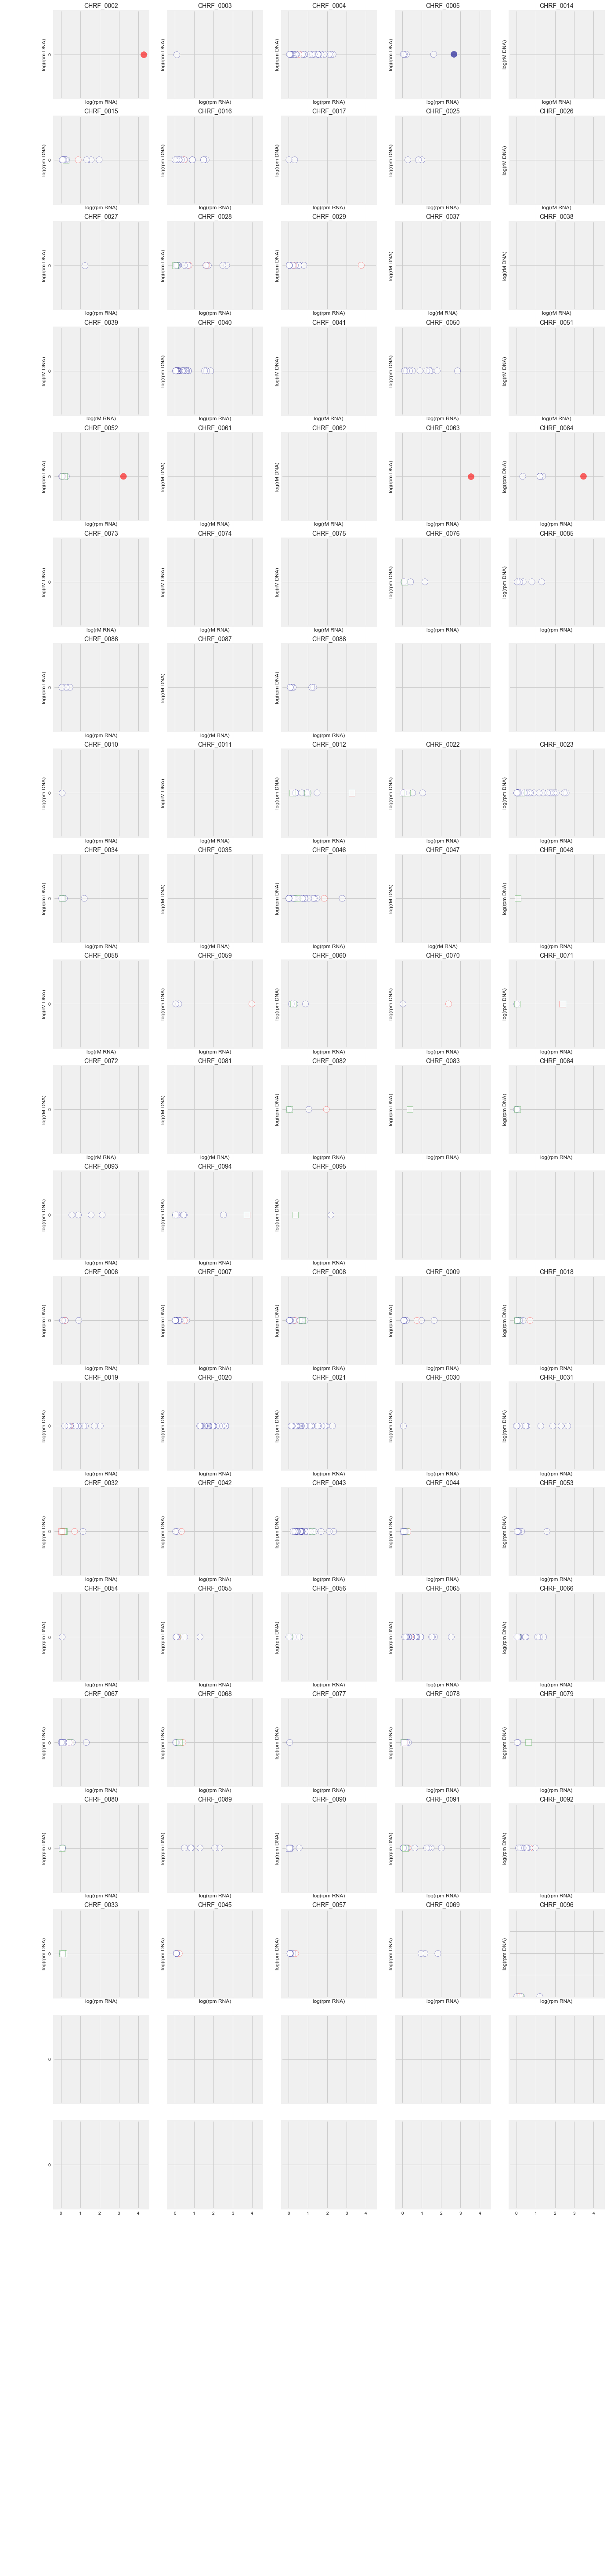

In [13]:
final_results = {}
top_microbes_file = open('./output/' + output_directory + '/top_microbes_by_patient.txt','w')

percent_represented_in_topX_RNA = []
percent_represented_in_topX_DNA = []

RNA_diversity = {}
DNA_diversity = {}

RNA_value = []
DNA_value = []
positive = []
pathogenic = []
virus = []
nrnt_model = []
groupid = []
microbe_id = []
microbe_id_genus = []
patient_id = []
ranks = []
nt_genusz_dna = []
nt_genusz_rna = []

RNA_value_test = []
DNA_value_test = []
positive_test = []
pathogenic_test = []
virus_test = []
nrnt_model_test = []
test_files = []

dna_present = False

sensitivity_analysis_results = {}

cultured_fill = ['none',]
cultured_colors = ['blue','red']

fig, axarr = plt.subplots(21,5, figsize=(20, 92), sharex=True, sharey=True)#, facecolor='white')

row = 0
col = 0

f = open('./output/' + output_directory + '/raw_data_pathogen_scoring.txt','w')
do_not_continue = False
ranks_from_culture = {}

list_of_files = list(bacterial.keys())
prev_sample_tc = 0

for i in ordered_list_of_files:   # loop through all files
    print(i)

    sample_id = i.split('/')[-1].split('.')[0].upper()
    metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]   
    
    tc = true_classification.loc[[sample_id],:]['effective_group'][0]   # set group ID
    ranks_from_culture[i] = []

    if tc == 1 or tc == 4 or tc ==3 or tc ==2 or tc == 5:

        if(not do_not_continue):
            
            # this modifies the scatterplot point shape based on the group, 
            # currently setting all to circles
            group = 'o'  
            
            # in the plot of log(RNA rpM) x log(DNA rpM) we want to divide into sections based 
            # on sample adjuciation - all samples from Group 1 are grouped together, followed by 
            # all samples in G2, etc. This section creates a new line whenever the group switches.
            if tc == 1 and prev_sample_tc < tc:
                print('hi')
            if tc == 2 and prev_sample_tc < tc:
                row += 1
                col = 0
            if tc == 3 and prev_sample_tc < tc:
                row += 1
                col = 0
            if tc == 4 and prev_sample_tc < tc:
                row +=1 # 0
                col = 0

            bac = full[i] 
            
            if('genus_NT_rpm DNA' in bac.columns):
                dna_present = True

            if(bac.shape[0] > 0):
                bac = bac.reset_index()
                
                # sort the operating matrix by column RPM
                bac.sort_values(by='genus_NT_rpm RNA', inplace=True, ascending=False)   
                bac = bac.reset_index() #reindex([i for i in range(len(bac.index))])
                
                # Keep track of the percent of all microbial rpM that are represented in the 
                # top 15 microbes. This threshold was selected based on the fact that all 
                # culture-identified microbes were present w/in the top 15. Here we quantify
                # the total % microbial represnted by this subset.
                try:
                    percent_represented_in_topX_DNA.append(bac.head(n=topX)['genus_NT_rpm DNA']
                                                           .sum()/bac['genus_genus_NT_rpm DNA'].sum())
                except:
                    print("could not append DNA % in top 15")
                try:
                    percent_represented_in_topX_RNA.append(bac.head(n=topX)['genus_NT_rpm RNA']
                                                           .sum()/bac['genus_NT_rpm RNA'].sum())
                except:
                    print("could not append RNA % in top 15")
                
                # topX allows us to select the top N microbes (15 for the purpose of the study)
                bac = bac.head(n=topX) 
                
                print(bac)
                
                if not dna_present:
                    bac['genus_NT_rpm DNA'] = [0 for i in range(len(bac['genus_NT_rpm RNA']))]
                
                if dna_present:
                    bac['genus_NT_rpm DNA scaled'] = (bac['genus_NT_rpm DNA']
                                                     /bac['genus_NT_rpm DNA'].sum())
                    DNA_diversity[i.split('/')[4].split('.')[0]] = (simpson_di(dict(bac['genus_NT_rpm DNA'])))
                
                bac['genus_NT_rpm RNA scaled'] = (bac['genus_NT_rpm RNA']
                                                 /bac['genus_NT_rpm RNA'].sum())              
                bac.fillna(0)
                
                RNA_diversity[i.split('/')[4].split('.')[0]] = (simpson_di(dict(bac['genus_NT_rpm RNA'])))
                
                # this outputs the full topX microbes (DNA and RNA data) to .txt file .
                top_microbes_file = open('./output/' + output_directory + 
                                         '/top_microbes_by_patient.txt','a')
                top_microbes_file.write("\n----\n" + i + "\n\n")
                top_microbes_file.close()
                top_microbes_file = open('./output/' + output_directory + 
                                         '/top_microbes_by_patient.txt','a')
                bac.to_csv('./output/' + output_directory + 
                           '/top_microbes_by_patient.txt', sep='\t', mode='a')
                top_microbes_file.write("\n\n")
                top_microbes_file.close()
                
                grew_in_culture = []   # fill color
                is_pathogen = []       # edge color
                is_virus = []          # shape (square = virus, circle = bacteria/fungi)
                nrnt_pointsize = []    # NO LONGER APPLICABLE

                bac = bac.dropna(axis=0, how='all')

                rank_number_identified = 0
                for n in bac.index:
                    rank_number_identified += 1   # increment with each microbe

                    
                    if dna_present:
                        # implementing a heuristic for assigning most likely 
                        # species to genus-level rpM
                        print(bac.columns)
                        curr_genus = bac.loc[n]['name_x']    # default is DNA species...
                        species_colID = 'name_x'

                        # ...but if RNA rM is greater, then set curr_genus to the RNA species
                        if bac.loc[n]['genus_NT_rpm DNA'] < bac.loc[n]['genus_NT_rpm RNA']:   
                            curr_genus = bac.loc[n]['name_y']
                            species_colID = 'name_y'
                    else:
                        curr_genus = bac.loc[n]['name_y']    # default is RNA species...
                        species_colID = 'name_y'
                            
                            
                    # TODO: Could remove this section - 
                    # no longer looking at NR:NT ratio for this paper
                    # if(with_nrnt_concordance):
                    if(True):
                        # get the genus to use as a tag for finding the concordance
                        #g = ' '.join(bac.loc[n]['genus_taxid'].split(' ')[0:-3])   
                        g = bac.loc[n]['genus_taxid'] 
                        try:
                            # try to append the NRNT point size
                            nrnt_pointsize.append(float(nrnt_values.loc[g]['prop'])) 
                            print("WEIRD...NRNT WAS FOUND: " + str(g))
                        except:   # if the NRNT value can't be found, just append zero...
                            # ...  cases in which it can't be found are when rM is extremely low
                            nrnt_pointsize.append(1)  #NO NRNT POINT SIZE

                    #
                    # set the facecolor of points based on classificaiton of microbe. Overall... 
                    # blue = non-pathogenic bacteria/fungi
                    # green = non-pathogenic virus
                    # red = pathogenic (bacteria, virus, or fungi)
                    #
                    
                    set_color = "darkblue"     # default blue
                    if (curr_genus in list_of_viruses_in_dictionary) or ('irus' in str(curr_genus)):  #if genus is any virus, green
                        set_color = "green"
                        is_virus.append("green")   
                    else:
                        is_virus.append('none')
                    # set red if pathogen, regardless of whether it was previously 
                    # set to green for "virus"; this means that viruses on list of pathogens
                    # will appear red, not green.

                    try:
                        if (curr_genus in full_respiratory_microbes_list) or (curr_genus.split(' ')[0] in full_respiratory_microbes_list):  
                            set_color = "red"
                    except:
                        if (curr_genus in full_respiratory_microbes_list):
                            set_color = "red"
                    
                    # to the vector of pathogenicity, append the color; red == pathogen
                    is_pathogen.append(set_color)  

                    
                    #
                    # set the fill color based on whether the microbe grew in culture
                    # colors are consistent with the outline colors when grew_in_culture is true,
                    # otherwise fill color is empty
                    # 
                    
                    #'''
                    if (tc == 1 or tc==2) and not (isinstance((metadata.loc[metadata_id]['organism']), float)): # this grew in culture
                        if bac.loc[n]['Species_Assignment'] in list(metadata.loc[metadata_id]['organism'].split(',')):      
                            ranks_from_culture[i].append(rank_number_identified)
                            grew_in_culture.append(set_color) 
                            #elif len(bac.loc[n]['Species_Assignment']) == 1 and sum([bac.loc[n]['Species_Assignment'] in i for i in list(metadata.loc[metadata_id]['organism'].split(','))]) > 0:
                            #ranks_from_culture[i].append(rank_number_identified)
                            #grew_in_culture.append(set_color) 
                        else:
                            grew_in_culture.append('white')     # this did not grow in culture
                    else:
                        #'''
                        # this was not in G1 or G2, therefore did not grow in culture 
                        grew_in_culture.append('white')    
                        
                    g = bac.loc[n]['genus_taxid']   # genus-level microbe ID
                    

                #
                # make plot of all microbes, split by individuals, weighted by nrnt concordance 
                #
        
                # this defines the plot structure - 5 columns, up to 21 rows 
                # (bc we have 100 samples)
                if row < 21 and col < 5: 
                
                    correct_species_names = []
                
                    # plot viruses a different shape
                    bac['is_pathogen'] = is_pathogen
                    bac['grew_in_culture'] = grew_in_culture
                    bac['nrnt_pointsize'] = nrnt_pointsize
                    bacv = bac[bac['category_name']=="Viruses"] 
                    baco = bac[bac['category_name']!="Viruses"] 
                    
                    
                    
                    axarr[row,col].scatter(np.log10((baco['genus_NT_rpm RNA']+1)),  
                           np.log10((baco['genus_NT_rpm DNA']+1)),
                           alpha = .6, edgecolor=baco['is_pathogen'], 
                           facecolor = baco['grew_in_culture'], 
                           marker='o', s =[max(j*200,20) for j in baco['nrnt_pointsize']]) 
                           #,linewidth='1.2' )
                    axarr[row,col].scatter(np.log10((bacv['genus_NT_rpm RNA']+1)),  
                           np.log10((bacv['genus_NT_rpm DNA']+1)),
                           alpha = .6, edgecolor=bacv['is_pathogen'], 
                           facecolor = bacv['grew_in_culture'], 
                           marker='s', s =[max(j*200,20) for j in bacv['nrnt_pointsize']]) 
                           #,linewidth='1.2' )

                    
                    '''
                    plt.scatter(np.log10((baco['genus_NT_rpm RNA']+1)),  
                           np.log10((baco['genus_NT_rpm DNA']+1)),
                           alpha = .6, edgecolor=bacv['is_pathogen'], 
                           facecolor = baco['grew_in_culture'], 
                           marker='o', s =[max(j*200,20) for j in baco['nrnt_pointsize']] )
                    plt.show()
                    '''
                    
                    
                    # loop through microbes and annotate the scatterplot with text 
                    for n in bac.index:
                        if(dna_present):
                            curr_genus = bac.loc[n]['name_x']    # default is DNA species...
                            species_colID = 'name_x'
                            # ... but if RNA rM is greater, then curr_genus is the rna genus
                            if bac.loc[n]['genus_NT_rpm DNA'] < bac.loc[n]['genus_NT_rpm RNA']:    
                                curr_genus = bac.loc[n]['name_y']
                                species_colID = 'name_y'
                        else:
                            curr_genus = bac.loc[n]['name_y']
                            species_colID = 'name_y'
                        #'''    
                        # annotate
                        axarr[row,col].annotate(bac.loc[n][species_colID], 
                                         (np.log10((bac.loc[n]['genus_NT_rpm RNA']+1)) + .1, 
                                         np.log10((bac.loc[n]['genus_NT_rpm DNA']+1)) - .1),
                                         fontsize=4, color='grey') 
                        
                        #'''
                        correct_species_names.append(bac.loc[n][species_colID])
                    

                    # set axis parameters and labels
                    #axarr[row,col].set_title(
                    #    'TA-'+i.split('/')[5].split('.')[0].split('-')[1], fontsize=14)
                    axarr[row,col].set_title(metadata_id, fontsize=14)
                    axarr[row,col].set_xticks(np.arange(0,4.5,1))
                    axarr[row,col].set_yticks(np.arange(0,4.5,1))
                    axarr[row,col].set_xlabel('log(rpm RNA)')
                    axarr[row,col].set_ylabel('log(rpm DNA)')
                    
                    #axarr[row,col].set_facecolor('white')

                    # if you have reached the last column of subplots, 
                    # move to the next row in subplot grid
                    if col == 4:
                        row += 1
                        col = 0
                    else:
                        col += 1

                    #
                    # CALCULATE/STRUCTURE VALUES TO BE PUT INTO LOGISTIC REGRESSION:
                    #
                       
                    #for sensitivity analysis with real model 
                    RNA_value = RNA_value + list(np.log10((bac['genus_NT_rpm RNA']+1))) 
                    if dna_present:
                        DNA_value = DNA_value + list(np.log10((bac['genus_NT_rpm DNA']+1)))  
                    else:
                        DNA_value = DNA_value + list([0 for i in range(len(bac['genus_NT_rpm RNA']))])
                        
                    positive = positive + grew_in_culture
                    pathogenic = pathogenic + is_pathogen
                    virus = virus + is_virus
                    nrnt_model = nrnt_model + nrnt_pointsize
                    groupid = groupid + [tc for l in range(len(nrnt_pointsize))]
                    microbe_id = microbe_id  + correct_species_names
                    microbe_id_genus = microbe_id_genus + [bac['genus_taxid'][i] for 
                                                           i in range(len(bac['genus_taxid']))]
                    patient_id = patient_id + [i.split('/')[-1] for 
                                               l in range(len(nrnt_pointsize))]
                    nt_genusz_rna = nt_genusz_rna + list(bac['NT_zscore RNA'])
                    if dna_present:
                        nt_genusz_dna = nt_genusz_dna + list(bac['NT_zscore DNA'])
                    else:
                        nt_genusz_dna = nt_genusz_dna + list([0 for i in range(len(bac['NT_zscore RNA']))])
                        
                    ranks = ranks + [j for j in range(len(bac.index))]
                    
                    
            # bac.shape was < 1, so no microbes identified - fill these values with zero. 
            else:  
                
                if row < 21 and col < 5:  # no real data to plot
                    
                    # just set axis parameters and labels
                    #axarr[row,col].set_title(
                    #    'TA-'+i.split('/')[5].split('.')[0].split('-')[1], fontsize=14)
                    axarr[row,col].set_title(metadata_id, fontsize=14)
                    axarr[row,col].set_xticks(np.arange(0,4.5,1)) 
                    axarr[row,col].set_yticks(np.arange(0,4.5,1)) 
                    axarr[row,col].set_xlabel('log(rM RNA)')
                    axarr[row,col].set_ylabel('log(rM DNA)')
                    #axarr[row,col].set_axis_bgcolor('white')

                    # if you have reached the last column of subplots, 
                    # move to the next row in subplot grid
                    if col == 4:
                        row += 1
                        col = 0
                    else:
                        col += 1
                        
    else:
        print("Warning: what is going on??")
    prev_sample_tc = tc

plt.savefig('./output/' + output_directory + '/FigureS1.pdf', transparent=True)   # save figure to .pdf file

In [14]:
RNA_diversity
#full_respiratory_microbes_list

{'chrf_rna_0002_s2': 1.0,
 'chrf_rna_0003_s3': 1.0,
 'chrf_rna_0004_s4': 0.15503550247757816,
 'chrf_rna_0005_s5': 0.8503856968992732,
 'chrf_rna_0006_s6': 0.7036420010180944,
 'chrf_rna_0007_s7': 0.25716853576172516,
 'chrf_rna_0008_s8': 0.17306037418246492,
 'chrf_rna_0009_s9': 0.5894662636785485,
 'chrf_rna_0010_s10': 1.0,
 'chrf_rna_0012_s12': 0.9370785486236922,
 'chrf_rna_0015_s15': 0.3964453153201936,
 'chrf_rna_0016_s16': 0.24030629045382984,
 'chrf_rna_0017_s17': 0.9286694101508914,
 'chrf_rna_0018_s18': 0.3963290968090859,
 'chrf_rna_0019_s19': 0.29363900061907916,
 'chrf_rna_0020_s20': 0.09162307147500956,
 'chrf_rna_0021_s21': 0.18052005578494856,
 'chrf_rna_0022_s22': 0.5946920935568105,
 'chrf_rna_0023_s23': 0.21653589305356963,
 'chrf_rna_0025_s25': 0.46996308166659906,
 'chrf_rna_0027_s27': 1.0,
 'chrf_rna_0028_s28': 0.37883295482635054,
 'chrf_rna_0029_s29': 0.9955564035932443,
 'chrf_rna_0030_s30': 1.0,
 'chrf_rna_0031_s31': 0.44260317488149525,
 'chrf_rna_0032_s32': 

The previous cell collected the % of total reads per million that were covered by the top N microbes, per patient on both RNA- and DNA-seq. This analysis presents statistics on the distribution of percent rpM represented.

In [15]:
print("RNA")
print(scipy.stats.describe(percent_represented_in_topX_RNA))
print("IQR:" + str(np.median(percent_represented_in_topX_RNA)-
                   scipy.stats.iqr(percent_represented_in_topX_RNA)) + " - " + 
      str(np.median(percent_represented_in_topX_RNA)+
          scipy.stats.iqr(percent_represented_in_topX_RNA)))

print("\nDNA")
pDNA = [i for i in percent_represented_in_topX_DNA if not np.isnan(i) ]
print(scipy.stats.describe(pDNA))
print("IQR: " + str(np.median(pDNA)-scipy.stats.iqr(pDNA)) + " - " + 
      str(np.median(pDNA)+scipy.stats.iqr(pDNA)))

total_topX = percent_represented_in_topX_RNA+pDNA
print("\nTOTAL")
print(scipy.stats.describe(total_topX))
print("IQR: " + str(np.median(total_topX)-scipy.stats.iqr(total_topX)) + " - " + 
      str(np.median(total_topX)+scipy.stats.iqr(total_topX)))

RNA
DescribeResult(nobs=72, minmax=(0.9269521069554915, 1.0), mean=0.9987286032168144, variance=7.596898282080731e-05, skewness=-7.951114943451198, kurtosis=62.73065044208356)
IQR:1.0 - 1.0

DNA


ValueError: The input must not be empty.

### Analysis of Ranks of NGS identification

> "To this point, while we detected all 39 pathogens identified from clinician-ordered microbiologic tests in the 26 LRTI+C+M patients using mNGS (Table S3), a ten-fold greater number of airway commensals were also identified."

The goal was to convey the fact that 100% of microbes identified by clinical culture were identified within the sequencing results. To accomplish this, I sought to generate a figure similar to Fig 2B from this paper: https://www.biorxiv.org/content/biorxiv/early/2017/08/17/177402.full.pdf


KeyError: "None of [['CHRF_0002']] are in the [index]"

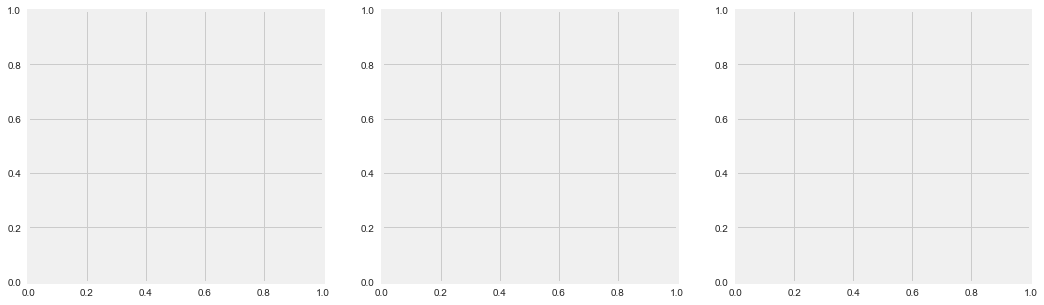

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

all_ranks = {}  # dictionary, keys are the ranks and values are the number of times a microbe had that rank
only_first_ranks = {}
s = 0
s2 = 0

for i in list_of_files:   # loop through all the files
    sample_id = i.split('/')[-1].split('.')[0].upper()
    #sample_id = i.split('/')[-1].split('.')[-3]   # get the sample ID from filename
    # get the metadata for that sample ID
    metadata_id = metadata.loc[metadata['sample_name_RNA'] == sample_id].index[0]   
    # get the true classification for that sample
    tc = true_classification.loc[[metadata_id],:]['effective_group'][0] 
    #print(tc)
    
    # use dictionary of ranks created while plotting per-sample rM RNA and rM DNA (above); 
    # parse for plotting.
    for j in ranks_from_culture[i]:   
        s += 1
        try:
            all_ranks[j] += 1
        except:
            all_ranks[j] = 1
    if(len(ranks_from_culture[i]) > 0):  # if something grew in culture
        s2 += 1
        try:
            only_first_ranks[ranks_from_culture[i][0]] += 1
        except:
            only_first_ranks[ranks_from_culture[i][0]] = 1
        

# plot the first panel with proportions of all microbes
(pd.Series(all_ranks)/s).plot('bar',width=.9, ax=axes[0],color='#007acc')

# plot the second panel with proportions including only the most abundant microbe per patient
(pd.Series(only_first_ranks)/s2).plot('bar',width=.9,ax=axes[1], color='#e6b800')

# loop through and convert count data to cummulative proportions
# cummulative proportions for the "all microbes" data
all_ranks_cummulative = all_ranks
all_ranks_cummulative[2] = all_ranks_cummulative[1] + all_ranks_cummulative[2]
all_ranks_cummulative[3] = all_ranks_cummulative[2] + all_ranks_cummulative[3]
all_ranks_cummulative[4] = all_ranks_cummulative[3] + all_ranks_cummulative[4]
all_ranks_cummulative[7] = all_ranks_cummulative[4] + all_ranks_cummulative[7]
if topX == 15:
    all_ranks_cummulative[10] = all_ranks_cummulative[10] + all_ranks_cummulative[7]
    all_ranks_cummulative[13] = all_ranks_cummulative[13] + all_ranks_cummulative[10]

# cummulative proportions for the "only top microbe" data
only_first_ranks_cummulative = only_first_ranks
only_first_ranks_cummulative[2] = (only_first_ranks_cummulative[1] + 
                                   only_first_ranks_cummulative[2])
only_first_ranks_cummulative[3] = (only_first_ranks_cummulative[2] +
                                   only_first_ranks_cummulative[3])
only_first_ranks_cummulative[4] = (only_first_ranks_cummulative[3] +
                                   only_first_ranks_cummulative[4])
    
# create a merged dataframe for final panel plot
cumm_rank_df = pd.DataFrame({'All Ranks': all_ranks_cummulative, 
                             'First Ranks': only_first_ranks_cummulative})
cumm_rank_df.fillna(26, inplace=True)
cumm_rank_df_norm = cumm_rank_df/cumm_rank_df.max()
cumm_rank_df_norm.columns=['All Microbes (including polymicrobial)',
                           'Most Abundant Pathogen per Patient']

# plot the side-by-side representation
ax = cumm_rank_df_norm.plot(kind="bar", ax=axes[2], color = ['#007acc','#e6b800']
                           ).legend(bbox_to_anchor=(.8, -.15))

# append details to the plot (axes and legend) on third panel
plt.yticks(np.arange(0,1.05,.1))
plt.ylim(0,1.05)
plt.xlabel("Culture Confirmed Rank")
plt.ylabel("Proportion of Samples")
plt.title("RNA-seq Rank of All Clinically-confirmed \nPathogens Including Multi-Culture")

plt.show()

# print the data used to generate the plots
print("Cummulative # of Microbes at each Rank:")
print(pd.Series(all_ranks_cummulative))

print("\nCummulative # of Top Microbes at each Rank:")
print(pd.Series(only_first_ranks_cummulative))

print("\n")
print(cumm_rank_df_norm)

In [68]:
# Get the sensitivity/specificity for identifying microbes as the patient-level.
# Did we pick up the microbe at all by NGS? 
# Note: This is separate from the linear model for identifying putative pathogens

had_cultured_organism = 0
at_least_one_organism_identified_by_ngs = 0
all_organisms_identified_by_ngs = 0
total_number_organisms_culture = 0
total_number_organisms_anyNGS = 0

for i in list_of_files:
    sample_id = i.split('/')[-1].split('.')[-3]
    metadata_id = metadata.loc[metadata['RNAfilename'] == sample_id].index[0]
    tc = true_classification.loc[[sample_id],:]['effective_group'][0]
    bac = full[i]

    try:
        if tc == 1:
            
            #cmd will fail if nan, so since it doesn't fail there was a cultured organism
            organism_list = metadata.loc[metadata_id]['organism'].split(',') 
            
            total_number_organisms_culture += len(organism_list)
            if(len(organism_list) > 0):    
                had_cultured_organism += 1
                ID_by_NGS = [bac.loc[i]['Genus'] for i in bac.index if 
                             bac.loc[i]['Genus'] in organism_list]
                
                total_number_organisms_anyNGS  += len(ID_by_NGS) 
                    
                if len(ID_by_NGS) > 0:
                    at_least_one_organism_identified_by_ngs += 1
                    
                if len(set(ID_by_NGS)) == len(set(organism_list)):
                    all_organisms_identified_by_ngs += 1
                else:
                    print(i.split('/')[-1] + " is missing the following organisms by NGS:")
                    print(set(organism_list)-set(ID_by_NGS))
    except:
        if tc == 1:
            #if tc is 1 and no organism is listed, we want to know...otherwise skip
            print(metadata.loc[metadata_id]['organism'])  

print("# of patients that had a cultured organism: " 
      + str(had_cultured_organism))
print('# of patients that had at least one cultured organism identified in NGS: '
      + str(at_least_one_organism_identified_by_ngs))
print('# of patients that had all cultured organisms identified in NGS: '
      + str(all_organisms_identified_by_ngs))

print('Total # of organisms in culture: ' 
      + str(total_number_organisms_culture))
print('Total # of organisms in culture, identified AT ALL by NGS: ' 
      + str(total_number_organisms_anyNGS))


IndexError: list index out of range

# Set-up Data from LR and RB Models

> "For both models, microbes identified by clinician-ordered diagnostics in LRTI+C+M patients and all viruses with established respiratory pathogenicity, were considered pathogens (n=12 in derivation cohort and n=26 in validation cohort, Table S1). Any additional microbes identified by NGS were considered commensals (n = 155 in derivation cohort, n=174 in validation cohort)."

This code creates the main data structure that will be used to implement the rules-based and logistic regression models - a dataframe with one line per sample containing 
- RNAvalue
- DNAvalue
- groupID
- rank
- microbeID
- patient
- pathogenicity
- virus status
- and whether the microbe was identified in culture.

In [17]:
# Parse out the relevant features from Figure S1 - generated in main analysis above.
sensitivity_DF = pd.DataFrame.from_dict({'RNAvalue':RNA_value,
                                         'DNAvalue':DNA_value,
                                         'groupID':groupid,
                                         'positive':positive,
                                         'pathogenic':pathogenic,
                                         'nrnt':nrnt_model,
                                         'ranks':ranks,
                                         'virus':virus,
                                         'microbe':microbe_id,
                                         'microbe_genus':microbe_id_genus, 
                                         'patient':patient_id, 
                                         'nt_Z_rna':nt_genusz_rna,
                                         'nt_Z_dna':nt_genusz_dna}, orient='columns')

X = sensitivity_DF[['RNAvalue','DNAvalue','nrnt','groupID','ranks','microbe',
                    'patient','microbe_genus','nt_Z_rna','nt_Z_dna']]
X[['pathogenic_red']] = sensitivity_DF[['pathogenic']] == 'red'
X[['pathogenic_green']] = sensitivity_DF[['virus']] == 'green'
X[['pathogenic_darkblue']] = sensitivity_DF[['pathogenic']] == 'darkblue'
X['positive'] = sensitivity_DF[['positive']]!="white"#"none"

# Full training dataset
X.fillna(0,inplace=True)
Y = X[['positive']]
Y = Y['positive'].tolist()

# Separate out by group membership for training and analysis of True Positive / True Negative
X_g1 = X[X['groupID'] == 1]
print(X_g1.shape)
X_g2 = X[X['groupID'] == 2]
print(X_g2.shape)
X_g3 = X[X['groupID'] == 3]
print(X_g3.shape)
X_g4 = X[X['groupID'] == 4]
print(X_g4.shape)
X_g1g4 = pd.concat([X_g1, X_g4], axis=0)

# generate the outcome vectors based on whether microbe was identified by standard microbiology
Y_g1 = X_g1[['positive']]
Y_g1 = Y_g1['positive'].tolist()
Y_g2 = X_g2[['positive']]
Y_g2 = Y_g2['positive'].tolist()
Y_g3 = X_g3[['positive']]
Y_g3 = Y_g3['positive'].tolist()
Y_g4 = X_g4[['positive']]
Y_g4 = Y_g4['positive'].tolist()
Y_g1g4 = X_g1g4[['positive']]
Y_g1g4 = Y_g1g4['positive'].tolist()

X.to_csv('./output/' + output_directory + '/microbe_model_data.csv')  # save full dataset to .csv
X.head() # demo of training data

(157, 14)
(0, 14)
(98, 14)
(284, 14)


,RNAvalue,DNAvalue,nrnt,groupID,ranks,microbe,patient,microbe_genus,nt_Z_rna,nt_Z_dna,pathogenic_red,pathogenic_green,pathogenic_darkblue,positive
0,4.281794,0,1,1.0,0,Streptococcus pneumoniae,chrf_rna_0002_s2.csv,1301,36.4,0,True,False,False,True
1,0.100371,0,1,1.0,0,Thermaerobacter marianensis,chrf_rna_0003_s3.csv,73918,2.8,0,False,False,True,False
2,2.298678,0,1,1.0,0,Massilia putida,chrf_rna_0004_s4.csv,149698,2.1,0,False,False,True,False
3,2.196784,0,1,1.0,1,Frondihabitans sp. PAMC 28766,chrf_rna_0004_s4.csv,447237,42.6,0,False,False,True,False
4,2.102296,0,1,1.0,2,Rothia mucilaginosa,chrf_rna_0004_s4.csv,32207,2.9,0,False,False,True,False


In [18]:
# separate G1/G4 data further into training and test sets 
# these sample names were identified by random selection of host RNA-seq data based on RNA-seq batches.
X_g1_train = X_g1[X_g1['patient'].isin(training_sample_names)]
X_g4_train = X_g4[X_g4['patient'].isin(training_sample_names)]
X_g1g4_train = pd.concat([X_g1_train,X_g4_train])
Y_g1_train = X_g1_train['positive'].tolist()
Y_g4_train = X_g4_train['positive'].tolist()

X_g1_test = X_g1[~X_g1['patient'].isin(training_sample_names)]
X_g4_test = X_g4[~X_g4['patient'].isin(training_sample_names)]
X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1_test = X_g1_test['positive'].tolist()
Y_g4_test = X_g4_test['positive'].tolist()

print("Training data contains: " + str(X_g1g4_train.shape[0]) + 
      " total microbes from 20 patients (in the LRTI+C/+M and LRTI-NEG training set), of which " + 
      str(X_g1g4_train[X_g1g4_train['positive']==True].shape[0]) + 
      " microbes are considered POSITIVE (grew in culture).")
print("The test data contains: " + str(X_g1g4_test.shape[0]) + 
      " total microbes from all remaining patients in the validation cohort, of which " + 
      str(X_g1g4_test[X_g1g4_test['positive']==True].shape[0]) + 
      " microbes are considered POSITIVE (grew in culture).")

Training data contains: 0 total microbes from 20 patients (in the LRTI+C/+M and LRTI-NEG training set), of which 0 microbes are considered POSITIVE (grew in culture).
The test data contains: 441 total microbes from all remaining patients in the validation cohort, of which 5 microbes are considered POSITIVE (grew in culture).


## Quantify the observation that RNA rpM is generally > DNA rpM 

> "RNA-Seq yielded a greater abundance of sequences as compared to DNA-seq for 79% of microbes, with a mean of 89 more reads per million reads mapped (rpm) than DNA-Seq (IQR: 0.11 - 29.0 rpm) per microbe."

In [23]:
# quantify the difference in RNA rpm v. DNA rpm 

# not including RNA viruses in this calculation bc they can't have DNA
not_virus = X[X['DNAvalue'] > 0]                                   
# reverse the log conversion to report true rpm difference
dif_RNAvDNAx = 10**not_virus['RNAvalue']-10**not_virus['DNAvalue']  
dif_RNAvDNA = (10**not_virus['RNAvalue'])/10**not_virus['DNAvalue']

# add column to dataframe to ease reporting of analysis
not_virus['RNAminusDNA'] = dif_RNAvDNA                             

# report the statistics:
print("% of all microbes with RNA > DNA rpM: " + str(sum(dif_RNAvDNAx > 0)/len(dif_RNAvDNA)))
print("Mean: " + str(np.mean(dif_RNAvDNA)))
print("Min: " + str(np.min(dif_RNAvDNA)))
print("25th percentile: " + str(np.percentile(dif_RNAvDNA, 25)))
print("50th percentile: " + str(np.percentile(dif_RNAvDNA, 50)))
print("75th percentile: " + str(np.percentile(dif_RNAvDNA, 75)))
print("Max: " + str(np.max(dif_RNAvDNA)))

# plot histogram of the differences
plt.hist(dif_RNAvDNA, bins=[i*5 for i in range(-10,20)])
plt.title("Distribution of RNA rpM - DNA rpM")
plt.xlabel("Difference between RNA rpM and DNA rpM")
plt.ylabel("Number of taxa")
plt.ylim(0,100)
plt.show()

ZeroDivisionError: division by zero

## Execute Rules-Based Model (RBM) for distinguishing between 'pathogens' and 'commensals'

> "In the RBM, respiratory microbes from each patient were assigned an abundance score based on the sum of log(RNA-Seq) and log(DNA-Seq) genus reads per million (rpm) (Table S3). Microbes were then ranked by this score, and the largest differential between sequentially ranked taxa was used as a threshold to isolate the group of highest-scoring microbes within each patient (Fig2A, Fig S1). These high scoring microbes plus all RNA viruses detected at > 0.1 rpm were captured as putative pathogens by the RBM if present in an a. priori developed index of established lower respiratory pathogens derived from landmark surveillance studies and clinical guidelines (Table S2B)"

Plot the RNA x DNA projection for all microbes - those identified by the RBM are filled, those identified by standard clinical microbiology are red.

In [19]:


def get_split(list_of_values):  #returns the index
    splits = {}
    max_split = 0
    max_split_id = 0
    split_list = []
    for i in range(len(list_of_values)):
        if i == 0:
            splits[i] = 0
            split_list.append(0)
        else:
            splits[i] = -1 * (list_of_values[i] - list_of_values[i-1] )
            split_list.append(splits[i])

        if splits[i] > max_split:
            max_split = splits[i]
            max_split_id = i

    return max_split_id
def apply_rule_based_method_cluster(input_data, input_res, groupID, output_filename, title=None, annotate_plots=False,rbm_method_plot=False):

    rbm1_patient = []
    rbm1_genus = []
    rbm1_microbe = []

    s = int(np.round(len(set(input_data['patient']))/5)+1)

    if rbm_method_plot:
        fig, axarr = plt.subplots(s,5, figsize=(20, s*4), sharex=True, sharey=True)
        row = 0
        col = 0

    for i in list(set(input_data['patient'])):#[0:3]:
        new_adds = 0
        #print(i)

        sub = input_data[input_data['patient']==i]
        sub['rna+dna'] = sub['RNAvalue'] + sub['DNAvalue']
        sub.sort_values(by='rna+dna', ascending=False, inplace=True)

        #ADD POTENTIAL BACTERIAL MICROBES
        subB = sub[sub['pathogenic_green'] == False] #cannot be a virus

        size_of_top_clust = get_split(list(subB['rna+dna']))
        # this was added on 12/28 to deal with cases in which only 1 bacterial microbe is present
        if(size_of_top_clust < 1):
            size_of_top_clust = 1 # there should always be at least 1 microbe in top cluster (if only 1 microbe present)


        ## NEW PLOTTING FUNCTION 2/1
        #plt.figure(figsize=[3,3])
        if rbm_method_plot:
            axarr[row,col].scatter([i for i in range(len(subB['rna+dna']))],subB['rna+dna'],color=[['darkblue','red'][int(i)] for i in subB['pathogenic_red']])
            axarr[row,col].axvline(x=size_of_top_clust - .5, color='r', linestyle='-',lw=.4)
            axarr[row,col].set_title(i)
            axarr[row,col].set_xlim(-1,15)
            axarr[row,col].set_ylim(-1,12)
            axarr[row,col].set_xticks(np.arange(0,15,1)) #MODS 2/1
            axarr[row,col].set_yticks(np.arange(0,12,1)) #MODS 2/1
            for l in range(len(subB.index)):
                axarr[row,col].annotate(subB.iloc[l]['microbe'],(l + .1,subB.iloc[l]['rna+dna']-.1),
                                 fontsize=8, color='grey')
            if col == 4:
                row += 1
                col = 0
            else:
                col += 1


        #print(size_of_top_clust)
        top = subB.head(n=size_of_top_clust)
        top = top[top['pathogenic_red'] == True]
        #print(top)
        for j in range(len(top.index)):
            rbm1_genus.append(str(top['microbe_genus'].iloc[j]))
            rbm1_microbe.append(str(top['microbe'].iloc[j]))
            new_adds += 1

        possible_viruses = sub[[(sub.loc[j]['pathogenic_green'] == True and sub.loc[j]['pathogenic_red'] == True) for j in sub.index]]
        possible_viruses = possible_viruses[possible_viruses['RNAvalue'] > np.log10(.1 + 1)] # RNAvalue is log10(RNA rpm + 1), and we want to keep viruses with rpm > .1
        if(len(possible_viruses.index) > 0):
            res = possible_viruses.head(n=1)
            for j in range(len(res.index)):
                rbm1_genus.append(str(res['microbe_genus'].iloc[j]))
                rbm1_microbe.append(str(res['microbe'].iloc[j]))
                new_adds += 1

        rbm1_patient = rbm1_patient + [i for n in range(new_adds)]

    rbm_g1 = pd.DataFrame.from_dict({'microbe': rbm1_microbe,'patient':rbm1_patient,'microbe_genus':rbm1_genus})
    rbm_g1.drop_duplicates(inplace=True)

    if groupID == 2:
        c = ['blue','blue']
    else:
        c = ['blue','red']

    if rbm_method_plot:
        plt.savefig(output_filename+"_methodplot.pdf")
        plt.show()

    #print([c[int(i)] for i in input_res])

    plt.figure(figsize=[8,8])
    a = [rbm_g1.iloc[i]['microbe'] + "-" + str(rbm_g1.iloc[i]['patient']) for i in range(len(rbm_g1))]
    match = [(str(input_data.iloc[i]['microbe']) + "-" + input_data.iloc[i]['patient'] in a) for i in range(len(input_data.index))]
    plt.scatter(input_data['RNAvalue'],input_data['DNAvalue'],
               edgecolor=[c[int(input_data.loc[i]['positive'])]
                       if input_data[input_data['patient'] == input_data.loc[i]['patient']]['positive'].sum() < 2
                       or c[int(input_data.loc[i]['positive'])] == 'blue'
                       or input_data.loc[i]['RNAvalue'] == max(input_data[(input_data.patient == input_data.loc[i]['patient']) & (input_data.positive == True)]['RNAvalue'])
                       else 'orange' for i in input_data.index],
                s=[85 if match[i] == 1 else 50 for i in range(len(match)) ],#linewidth='1.2',
                facecolor = [c[input_res[i]] if match[i] == 1 else 'white' for i in range(len(match)) ], alpha=.7)
                #facecolor=[c[int(Y_g2[i])] if predicted[:,1][i] > probability_threshold else 'white' for i in range(len(Y_g2)) ],alpha=.6) #s=predicted[:,1]*200
    
    if(annotate_plots):
        for i in range(len(input_res)):
            #if(predicted[:,1][i] > probability_threshold):
            if input_res[i] or match[i] == 1: #if the microbe was True in input_res
                try:
                    sp = input_data.iloc[i]['microbe'].split(' ')
                except:
                    sp = 'NA'
                pa = input_data.iloc[i]['patient'].split('-')[1]
                plt.annotate(sp[0][0] + '. ' + sp[1] + ' - ' + pa,(input_data.iloc[i]['RNAvalue'] + .1,input_data.iloc[i]['DNAvalue']-.1),
                             fontsize=5, color='grey')

    plt.xlim((-.2, 5.5))
    plt.ylim((-.2, 5.5))
    if not title == None:
        plt.title(title)
    else:
        plt.title("Group " + str(groupID) + " - Rule Based Method")
    #plt.axis((-1,12,-1,12))
    plt.xlabel('log( RNA rpM )' )
    plt.ylabel('log( DNA rpM )' )
    plt.savefig(output_filename + ".pdf")

    return rbm_g1

Group 1 RBM Results:


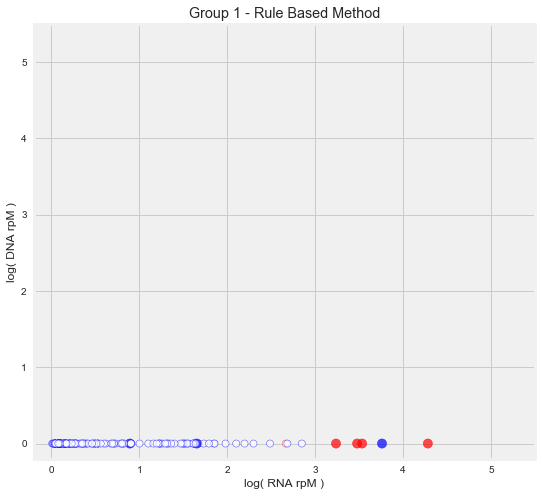

Group 2 RBM Results:


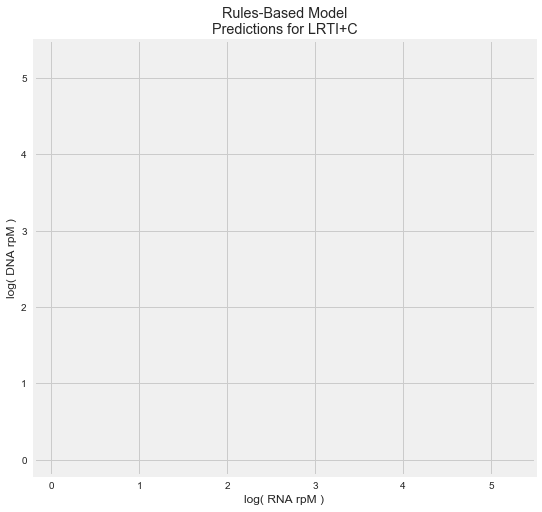

Group 3 RBM Results:


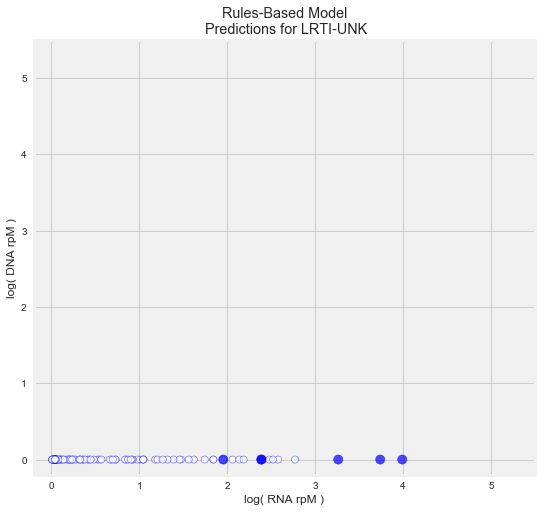

Group 4 RBM Results:


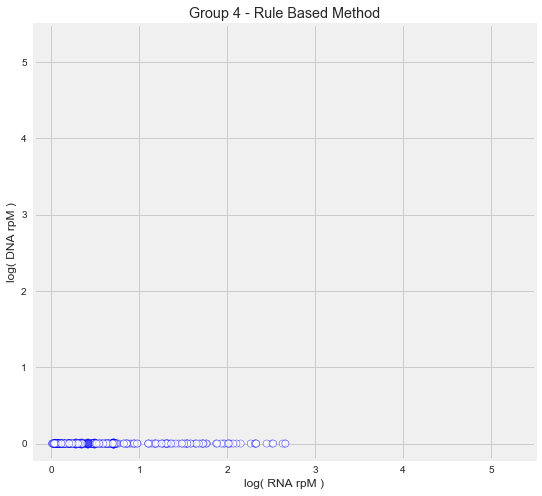

'\n# Evaluate RBM sensitivity against culture results\n# NOTE: this sensitivity calculation is at the per-patient level (as opposed to per-microbe); \n# OUTDATED.\nprint("Group 1 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g1,list_of_files, metadata, \n    true_classification, full, output_directory)\nprint("Group 2 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g2,list_of_files, metadata, \n    true_classification, full, output_directory)\nprint("Group 3 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g3,list_of_files, metadata, \n    true_classification, full, output_directory)\nprint("Group 4 RBM Results:")\nplotting_functions.evaluate_sensitivity(rbm_g4,list_of_files, metadata, \n    true_classification, full, output_directory)\n'

In [20]:
annotate_plots = False # do not want to write microbe names on the plots

# run RBM on Group 1 and Group 4 to generate the combined prediction Figure 2A
# We don't care about training and test sets in the RBM because each sample is 
# processed entirely independently

print("Group 1 RBM Results:") # Group 1 Only
rbm_g1 = apply_rule_based_method_cluster(X_g1, 
                                                            Y_g1, 
                                                            1, 
                                                            './output/' + output_directory +
                                                            '/rbm_1', 
                                                            rbm_method_plot=False)
rbm_g1.to_csv('./output/' + output_directory + '/RBM_G1.csv')
plt.show()

print("Group 2 RBM Results:") # Group 2 Only
rbm_g2 = apply_rule_based_method_cluster(
    X_g2, 
    Y_g2,
    2,
    './output/' + output_directory + '/FigureS3A',
    title="Rules-Based Model\n Predictions for LRTI+C ",
    rbm_method_plot=False)
rbm_g2.to_csv('./output/' + output_directory + '/RBM_G2.csv')
plt.show()

print("Group 3 RBM Results:") # Group 3 Only
rbm_g3 = apply_rule_based_method_cluster(
    X_g3,                                                         
    Y_g3, 
    3, 
    './output/' + output_directory + '/FigureS3C', 
    title="Rules-Based Model\n Predictions for LRTI-UNK", 
    rbm_method_plot=False)
rbm_g3.to_csv('./output/' + output_directory + '/RBM_G3.csv')
plt.show()

print("Group 4 RBM Results:") # Group 4 Only
rbm_g4 = apply_rule_based_method_cluster(
    X_g4, 
    Y_g4, 
    4, 
    './output/' + output_directory + '/rbm_4', 
    rbm_method_plot=False)
rbm_g4.to_csv('./output/' + output_directory + '/RBM_G4.csv')
plt.show()

# rbm_g1 - rbm_g4 results are saved and appended to output TableS3.

'''
# Evaluate RBM sensitivity against culture results
# NOTE: this sensitivity calculation is at the per-patient level (as opposed to per-microbe); 
# OUTDATED.
print("Group 1 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g1,list_of_files, metadata, 
    true_classification, full, output_directory)
print("Group 2 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g2,list_of_files, metadata, 
    true_classification, full, output_directory)
print("Group 3 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g3,list_of_files, metadata, 
    true_classification, full, output_directory)
print("Group 4 RBM Results:")
plotting_functions.evaluate_sensitivity(rbm_g4,list_of_files, metadata, 
    true_classification, full, output_directory)
'''

# Train and Evaluate Logistic Regression Model (LRM) 

First, for distinguishing between 'pathogens' and 'commensals'; then, for separating LRTI+C+M and no-LRTI patients.

> "We thus employed machine learning to distinguish respiratory pathogens from commensals using a logistic regression model (LRM) trained on microbes detected in derivation cohort patients using the predictor variables of: RNA-Seq rpm, DNA-Seq rpm, rank by RNA-Seq rpm, established LRTI pathogen (yes/no), and virus (yes/no). These features were selected to preferentially favor highly abundant organisms with established pathogenicity in the lung, but still permit detection of uncommon taxa that could represent putative pathogens. "

# Training v. Test Set - LR Analysis 

## Assess Model Stability:
Run LR model for 1000 rounds of cross-validation within the Derivation Cohort, further splitting the data intoa training set = 70% and test set = 30% at each iteration.

> "To evaluate LRM performance, we first performed 1000 rounds of cross-validation in which we randomly sub-divided the derivation cohort into training (70%) and test (30%) sets during each round, which yielded an average AUC of 0.93 +/- 0.08 standard deviations."

In [19]:
# SAME AS BLOCK BELOW BUT WITH "_iterative" appended to AUC plot 

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

print("sklearn version:")
print(sklearn.__version__)

PROBABILITY_THRESHOLD = 0.36 # 0.38 #0.278 #

print("Basic Stats about number of Positive/Negative Cases and Features of each group:\n")
X_pos = X_g1g4_train[X_g1g4_train['positive'] == True]
X_neg = X_g1g4_train[X_g1g4_train['positive'] == False]
print("Number of PATHOGENS in the training set:")
print(X_pos.shape)
print("Number of COMMENSALS in the training set:")
print(X_neg.shape)
print("\nRNA: wilcox p = ",
      str(scipy.stats.ranksums(X_pos[['RNAvalue']],X_neg[['RNAvalue']]).pvalue))
print("DNA: wilcox p = ",
      str(scipy.stats.ranksums(X_pos[['DNAvalue']],X_neg[['DNAvalue']]).pvalue))
print("RANKS: wilcox p = ",
      str(scipy.stats.ranksums(X_pos[['ranks']],X_neg[['ranks']]).pvalue))
print("is respiratory pathogen: Percent in PATHOGENS = " + 
      str(Counter(list(X_pos['pathogenic_red']))[True]/X_pos.shape[0]) + 
      ", Percent in COMMENSALS = " + 
      str(Counter(list(X_neg['pathogenic_red']))[True]/X_neg.shape[0]))
print("is virus: Percent in PATHOGENS = " + 
      str(Counter(list(X_pos['pathogenic_green']))[True]/X_pos.shape[0]) +
      ", Percent in COMMENSALS = " + 
      str(Counter(list(X_neg['pathogenic_green']))[True]/X_neg.shape[0]))
print("\n-----")



training_variables = ['RNAvalue','DNAvalue','pathogenic_red','pathogenic_green','ranks']
many_rounds_train_auc = []
many_rounds_test_auc = []

tprs_iterative = []
aucs_iterative = []
mean_fpr_iterative = np.linspace(0, 1, 100)

#X = X_g1g4_train[training_variables] 

X_combo = pd.concat([X_g1_train,X_g4_train])  # train on both group 1 and group 4 patients
y_combo = Y_g1_train + Y_g4_train   

# track num iterations w/ 1 class (likely the negative class) in the test set
oneclasspresent = 0    
c = ['blue','red']

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(
        X_combo[training_variables], y_combo, test_size=0.3
    ) 
    
    try:
        lr = linear_model.LogisticRegression(C=1000000)
        lr.fit(X_train, y_train)
        
        many_rounds_train_auc.append(
            metrics.roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
        many_rounds_test_auc.append(
            metrics.roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))
        
        fpr, tpr, thresholds = metrics.roc_curve(
            y_test, lr.predict_proba(X_test)[:,1], pos_label=1)  
        tprs_iterative.append(interp(mean_fpr_iterative, fpr, tpr))
        tprs_iterative[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs_iterative.append(roc_auc)
        
    except:
        # if only 1 class is present, cannot compute the req'd stats; skip this iteration
        oneclasspresent += 1    

print("\nWARNING: only one class was present in the test set for " + str(oneclasspresent) +
      " rounds of train/test split")
print("\n-----\n\nOutput metrics (at threshold = " + str(PROBABILITY_THRESHOLD) + ")")
print("Logistic regression Train AUC for 1000 rounds CV :: ", np.mean(many_rounds_train_auc))
print("Logistic regression Test AUC for 1000 rounds CV :: ", np.mean(many_rounds_test_auc))

sklearn version:
0.18.1
Basic Stats about number of Positive/Negative Cases and Features of each group:

Number of PATHOGENS in the training set:
(0, 14)
Number of COMMENSALS in the training set:
(0, 14)

RNA: wilcox p =  nan
DNA: wilcox p =  nan
RANKS: wilcox p =  nan


ZeroDivisionError: division by zero

## Obtain final predictions (separating true Training and Test sets)

### Leave-one-patient-out (LOPO) cross-validation to obtain Training Set predictions

LOPO-CV enables us to produce microbe predictions for all microbes in patients in the pre-established derivation set.

In [20]:
# LOPO-CV schematic is as follows:
# IN EACH ITERATION...
#  1. Remove all microbes from one patient
#  2. Train on microbes from all other patients
#  3. Predict for all microbes in the held-out patient
# This results in the predicted [pathogen v. commensal] probability for each microbe 
# in the training set

#
# RUN LOPO-CV ON ALL GROUP 1 AND GROUP 4 PATIENTS
#


# full training data
X_combo = X_g1g4_train 
Y_combo = X_combo[['positive']]

patients_to_remove = list(set(X_combo['patient']))  # names of each patient in the training set
predictions = []
truths = []
training_auc = []
c = ['blue','red']
patient_max_scores = {}
patient_groups = {}

for i in patients_to_remove:  # loop through all patients
    
    # training set is all combo microbes that are not from patient = i
    X_train_sub = X_combo[X_combo['patient'] != i]   
    X_train = X_train_sub[training_variables] 
    y_train = X_train_sub['positive']

    # test set is all combo microbes that are from patient = i
    X_test_sub = X_combo[X_combo['patient'] == i]   
    X_test = X_test_sub[training_variables] 
    y_test = X_test_sub['positive']

    lr = linear_model.LogisticRegression(C=1000000) # large C, effectively no regularization
    lr.fit(X_train, y_train)                        # fit the logistic regression model
    p_test = lr.predict_proba(X_test)[:,1]          # predict on the left-out sub test set
    p_train = lr.predict_proba(X_train)[:,1]        # predict on the training set 
    
    # METRICS for evaluating model performance
    # append subset predictions to list of all predictions
    predictions = predictions + list(p_test)
    # append truth values to list of all true classifications
    truths = truths + list(y_test)
    # calculate AUC for training subset
    training_auc.append(metrics.roc_auc_score([int(j) for j in y_train], p_train))  
        
    # track the maximum pathogen v. commensal score per patient
    patient_max_scores[i] = max(list(p_test))  
    patient_groups[i] = list(X_test_sub['groupID'])[0]   # track the LRTI group
        
    count = 0
    
    # append the pathogen v. commensal LRM "score" value to each row of the X_combo matrix ...
    # ... for downstream plots 
    for j in X_combo[X_combo['patient'] == i].index:  
        X_combo.loc[j,'score'] = p_test[count]
        count += 1
        
print("Mean AUC for LOPO-CV training: " + str(np.mean(training_auc)))  
print("\nTotal AUC for LOPO-CV predictions: " + str(metrics.roc_auc_score([int(i) for 
                                                                           i in truths], 
                                                                          predictions)))
pathogen_functions.get_CI([int(i) for i in truths], predictions, 1000);

# Youden's index for pathogen v. commensal model 
# We are not using this in the analysis for consistency in threshold btwn pathogen v. 
# commensal and LRTI v. no-LRTI models
# youdens_patho_commensal_model = pathogen_functions.Find_Optimal_Cutoff([int(i) for i in truths],
#                                                                            predictions)
# print("Youden's training pathogen v. commensal: " + str(youdens_patho_commensal_model))

Mean AUC for LOPO-CV training: nan


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

#### Training Set: Use the max. LRM score per patient to distinguish between LRTI v. no-LRTI patients

> "We recognized that the highest per-patient LRM pathogen versus commensal probability value differed significantly between LRTI+C+M and no-LRTI subjects (p = 3.8 x 10-4 by Wilcoxon rank sum). As such, we hypothesized that this value might have utility not only for pathogen versus commensal prediction, but also for LRTI prediction in general. We tested this idea and found that the maximum per patient LRM probability value predicted LRTI status with an AUC of 0.97 (95% CI = 0.90 - 1.00) in the derivation cohort and 0.93 (95% CI = 0.82 - 1.00) in the validation cohort (Figs 2B, S3)"

In [21]:
# USE THE PATIENT-SPECIFIC MAX SCORE VALUE TO CREATE A CLASSIFIER FOR G1 V. G4 PATIENTS...
# actually, we only have 1 feature so we will just evaluate the AUC.

scores = []
group = []
patient_names = []
for i in patient_max_scores.keys():
    scores.append(patient_max_scores[i])
    group.append(patient_groups[i])
    patient_names.append(i)

# Generate AUC curve for predicting Group 1 v. Group 4 from the top microbe score
#youdens_patient_microbe_model = pathogen_functions.Find_Optimal_Cutoff(group, scores)
#print("Youden's training patient microbe: " + str(youdens_patient_microbe_model))
fpr, tpr, thresholds = metrics.roc_curve(group, scores, pos_label=1)  
print("AUC for distinguishing LRTI+C+M v. no-LRTI patients = " + 
      str(metrics.roc_auc_score([int(i==1) for i in group], scores)))
pathogen_functions.get_CI([int(i==1) for i in group], scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(pathogen_functions.perf_measure([i > PROBABILITY_THRESHOLD for i in scores], 
                                      [int(i==1) for i in group]))


# PLOT: Figure S3
# AUC curve for LRTI+C+M v. no-LRTI using the max. pathogen v. commensal probability per patient
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b', lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model LOOCV Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2.pdf')
plt.show()

# PLOT: max predicted probability score by patient - for visualization and 
# double-checking feasability of AUC
plt.ylabel("Top Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(patient_max_scores, orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == 1) for i in group]
df.sort_values(by=0,inplace=True)
df[0].plot(kind='bar',color='grey',figsize=(10,4), alpha=.4)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
plt.show()
print(df[0])  # print out the patient ID and max microbe score (same as plot)


# evaluate the p-value of scores from group 1 and group 4
group1_scores = []
group4_scores = []
for i in range(len(group)):
    if int(group[i] == 1):
        group1_scores.append(scores[i])
    else:
        group4_scores.append(scores[i])

print("P-value for top microbe score in LRTI+C/M versus LRTI-NEG: " + 
      str(scipy.stats.ranksums(group1_scores,group4_scores).pvalue))

# Create the data for per-patient heatmap view showing all microbes that passed 
# the threshold for all patients (in groups 1 and group 4)
creating_matrix_from_Xcombo = X_combo[X_combo['score'] > PROBABILITY_THRESHOLD]
patient_by_microbe_predicted_combo = creating_matrix_from_Xcombo[['microbe',
                                                                  'patient',
                                                                  'microbe_genus']]
patient_by_microbe_predicted_combo.index = [i for i in range(len(
    patient_by_microbe_predicted_combo.index))]


IndexError: index -1 is out of bounds for axis 0 with size 0

### Pathogen v. Commensal LRM model applied to Test Set and LRTI+C and unk-LRTI patient groups

> "We found that both the RBM and the LRM identified previously occult putative pathogens in patients with clinically adjudicated LRTI but negative microbiologic testing (LRTI+C), as well as new potential co-infecting pathogens in the LRTI+C+M subjects (Figs 3, S2, Table S3). Putative new pathogens were identified in 21 (62%) of LRTI+C subjects using the RBM, and 21 (62%) via the LRM (Fig S2, Table S3). Both methods enabled a microbiologic diagnosis in a greater number of LRTI-positive subjects compared to clinician-ordered diagnostics (78% vs 43% for both RBM  and LRM (p < 1.00 x10-4 by McNemar's test, respectively) (Fig 3)."

How to interpret the following plots:
- IF THE EDGE IS RED, it was identified in culture (and should be filled in, true positive)
- IF a red edge is not filled in, then it is a false negative.
- IF an edge is blue, then it was not identified in culture (and should not be filled in, true negative)
- IF a blue circle is filled in then it is a false positive.

'\n\n# unk-LRTI PREDICTIONS\npredicted = lr.predict_proba(X_g3[training_variables]) \nplt.figure(figsize=[8,8])\nplt.scatter(X_g3[\'RNAvalue\'],X_g3[\'DNAvalue\'],\n            edgecolor=[c[int(i)] for i in Y_g3],\n            s=[max(i*200,20) for i in predicted[:,1]],\n            #linewidth=\'1.2\',\n            facecolor=[c[int(Y_g3[i])] if predicted[:,1][i] > \n                       PROBABILITY_THRESHOLD else \'none\' for i in range(len(Y_g3)) ],\n            alpha=.6)\nxlim((-.2, 4.5))\nylim((-.2, 4.5))\nif(annotate_plots):\n    for i in range(len(Y_g3)):\n        if True:\n            try:\n                sp = X_g3.iloc[i][\'microbe\'].split(\' \')\n            except: \n                sp = \'NA\'\n            pa = X_g3.iloc[i][\'patient\'].split(\'-\')[1]\n            plt.annotate(sp[0][0] + \'. \' + sp[1] + \' - \' + pa,\n                         (X_g3.iloc[i][\'RNAvalue\'] + .1,\n                          X_g3.iloc[i][\'DNAvalue\']-.1), \n                         fontsize=7

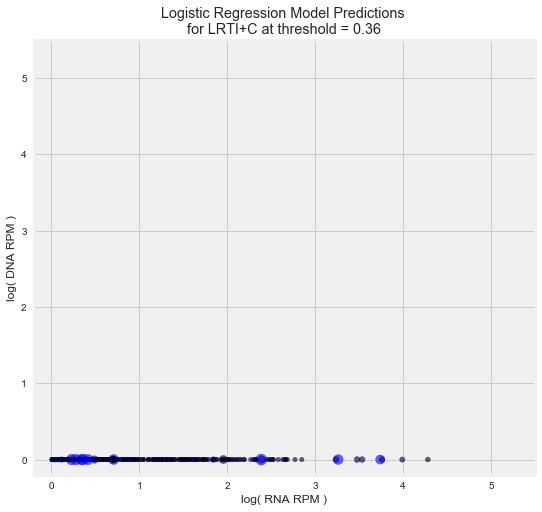

In [21]:
# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

'''

# create fresh linear model; large C to run non-regularized regression
lr = linear_model.LogisticRegression(C=1000000)
training_variables = ['RNAvalue','DNAvalue','pathogenic_red','pathogenic_green','ranks']

# Train on all Group 1 and Group 4 patients
lr = lr.fit(X_combo[training_variables],Y_combo)

print("LRM Model Coefficients for final pathogen v. commensal trained model:")
print(training_variables)
print(lr.coef_)

# save the combined model to a pickle file 
pickle.dump(lr, open('./output/' + output_directory + '/mBAL_g1g4combo_logRegModel', 'wb'))  

'''

lr = pickle.load( open( "/Users/kkalantar/Documents/Research/MBAL/miniBAL_study/output/042618/mBAL_g1g4combo_logRegModel", "rb" ) )
training_variables = ['RNAvalue','DNAvalue','pathogenic_red','pathogenic_green','ranks']
PROBABILITY_THRESHOLD = .36

#
# TRAIN ON ALL TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red'] # for G1 and G4 projection plot 
                   # (where some microbes were identified by clinical microbiology)
c2 = ['blue','red'] # for G2 and G3 projection pplots



annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 patients' microbes
predicted = lr.predict_proba(X[training_variables])
plt.figure(figsize=[8,8])
plt.scatter(X['RNAvalue'],X['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y],
            s=[max(i*200,20) for i in predicted[:,1]],
            #linewidth='1.2',
            facecolor=[c[int(Y[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y)) ],
            alpha=.6) 

xlim((-.2, 5.5))
ylim((-.2, 5.5))
if(annotate_plots):
    for i in range(len(Y)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X.iloc[i]['RNAvalue'] + .1,X.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')     
plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')
patient_by_microbe_predicted_g2 = pd.DataFrame.from_dict({
    'microbe':[X.iloc[i]['microbe'] for i in range(len(Y))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X.iloc[i]['patient'] for i in range(len(Y))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X.iloc[i]['microbe_genus'] for i in range(len(Y)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})

# append the group 2 pathogen v. commensal model to the original data matrix
X['score'] = predicted[:,1]


'''
# establish the test set
X_g1g4_test = pd.concat([X_g1_test,X_g4_test])
Y_g1g4_test = list(X_g1g4_test['positive'])

print("\n # of Pathogens v. Commensals in Training and Test sets, respectively:")
print(Counter(Y_combo['positive']))
print(Counter(Y_g1g4_test))

# Plot predicted probabilities for group 1 TEST SET patients' microbes
predicted = lr.predict_proba(X_g1g4_test[training_variables])
X_g1g4_test['score'] = predicted[:,1]  # append the predicted probabilities to the data matrix

# PLOT: RNA v. DNA plot with microbes shown with probabilities.
plt.figure(figsize=[8,8])

# visualize the test set in RNA rM by DNA rM space;
plt.scatter(X_g1g4_test['RNAvalue'],
            X_g1g4_test['DNAvalue'],
            edgecolor=[c[int(X_g1g4_test.loc[i]['positive'])] 
                       if X_g1g4_test[X_g1g4_test['patient'] == 
                                      X_g1g4_test.loc[i]['patient']]['positive'].sum() < 2 
                       or c[int(X_g1g4_test.loc[i]['positive'])] == 'blue' 
                       or X_g1g4_test.loc[i]['score'] == max(
                           X_g1g4_test[(X_g1g4_test.patient == X_g1g4_test.loc[i]['patient']) 
                                       & (X_g1g4_test.positive == True)]['score']) 
                       else 'orange' for i in X_g1g4_test.index],
            s=[max(i*600,3) for i in X_g1g4_test['score']],
            linewidth='1.2',
            facecolor=[c[int(Y_g1g4_test[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y_g1g4_test)) ],
            alpha=.7) 

# add the scatterplot of predicted TRAINING microbes in RNA rM by DNA rM space;
plt.scatter(X_combo['RNAvalue'],
            X_combo['DNAvalue'],
            edgecolor=[c[int(X_combo.loc[i]['positive'])] 
                       if X_combo[X_combo['patient'] == 
                                  X_combo.loc[i]['patient']]['positive'].sum() < 2 
                       or c[int(X_combo.loc[i]['positive'])] == 'blue' 
                       or X_combo.loc[i]['score'] == max(
                           X_combo[(X_combo.patient == X_combo.loc[i]['patient'])
                                   & (X_combo.positive == True)]['score']) 
                       else 'orange' for i in X_combo.index],
            s=[max(i*600,3) for i in X_combo['score']],
            linewidth='1.2',
            facecolor=[c2[int(X_combo.iloc[i]['positive'])] if X_combo.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(X_combo['positive'])) ],
            alpha=.4)

xlim((-.2, 4.5))
ylim((-.2, 4.5))
plt.title(
    "Logistic Regression Model Predictions \nfor LRTI+C/M and LRTI-NEG at probability score threshold = " + 
    str(PROBABILITY_THRESHOLD))
plt.xlabel("log( RNA rpM )")
plt.ylabel("log( DNA rpM )")
plt.savefig('./output/' + output_directory + '/Figure2D.pdf')

if(annotate_plots):
    for i in range(len(Y_g1g4_test)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X_g1g4_test.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X_g1g4_test.iloc[i]['RNAvalue'] +
                          .1,X_g1g4_test.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, color='grey')     
    
plt.show()


# save the predicted probabilities for each microbe to write to file downstream
patient_by_microbe_predicted_g1g4_test = pd.DataFrame.from_dict({
    'microbe': [X_g1g4_test.iloc[i]['microbe'] for i in range(len(Y_g1g4_test))
         if predicted[:,1][i] > PROBABILITY_THRESHOLD ],
    'patient':[X_g1g4_test.iloc[i]['patient'] for i in range(len(Y_g1g4_test))
               if predicted[:,1][i] > PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g1g4_test.iloc[i]['microbe_genus'] for
                     i in range(len(Y_g1g4_test))if predicted[:,1][i] > 
                                   PROBABILITY_THRESHOLD ]})

print("\n\n")
'''

#
# Predictions for Group 2 (LRTI+C) and Group 3 (unk-LRTI) patients
#

# LRTI+C PREDICTIONS

'''
annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 patients' microbes
predicted = lr.predict_proba(X_g2[training_variables])
plt.figure(figsize=[8,8])
plt.scatter(X_g2['RNAvalue'],X_g2['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y_g2],
            s=[max(i*200,20) for i in predicted[:,1]],
            #linewidth='1.2',
            facecolor=[c[int(Y_g2[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y_g2)) ],
            alpha=.6) 

xlim((-.2, 5.5))
ylim((-.2, 5.5))
if(annotate_plots):
    for i in range(len(Y_g2)):
        if(predicted[:,1][i] > PROBABILITY_THRESHOLD):
            sp = X_g2.iloc[i]['microbe'].split(' ')
            plt.annotate(sp[0][0] + '. ' + sp[1],
                         (X_g2.iloc[i]['RNAvalue'] + .1,X_g2.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')     
plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')
patient_by_microbe_predicted_g2 = pd.DataFrame.from_dict({
    'microbe':[X_g2.iloc[i]['microbe'] for i in range(len(Y_g2))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X_g2.iloc[i]['patient'] for i in range(len(Y_g2))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g2.iloc[i]['microbe_genus'] for i in range(len(Y_g2)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})

# append the group 2 pathogen v. commensal model to the original data matrix
X_g2['score'] = predicted[:,1]
'''


'''

# unk-LRTI PREDICTIONS
predicted = lr.predict_proba(X_g3[training_variables]) 
plt.figure(figsize=[8,8])
plt.scatter(X_g3['RNAvalue'],X_g3['DNAvalue'],
            edgecolor=[c[int(i)] for i in Y_g3],
            s=[max(i*200,20) for i in predicted[:,1]],
            #linewidth='1.2',
            facecolor=[c[int(Y_g3[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(Y_g3)) ],
            alpha=.6)
xlim((-.2, 4.5))
ylim((-.2, 4.5))
if(annotate_plots):
    for i in range(len(Y_g3)):
        if True:
            try:
                sp = X_g3.iloc[i]['microbe'].split(' ')
            except: 
                sp = 'NA'
            pa = X_g3.iloc[i]['patient'].split('-')[1]
            plt.annotate(sp[0][0] + '. ' + sp[1] + ' - ' + pa,
                         (X_g3.iloc[i]['RNAvalue'] + .1,
                          X_g3.iloc[i]['DNAvalue']-.1), 
                         fontsize=7, 
                         color='grey')  
plt.title("Logistic Regression Model Predictions \nfor LRTI-UNK at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel('log( RNA RPM )')
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3D.pdf')
patient_by_microbe_predicted_g3 = pd.DataFrame.from_dict({
    'microbe':[X_g3.iloc[i]['microbe'] for i in range(len(Y_g3))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD ],
    'patient':[X_g3.iloc[i]['patient'] for i in range(len(Y_g3))if predicted[:,1][i] > 
               PROBABILITY_THRESHOLD],
    'microbe_genus':[X_g3.iloc[i]['microbe_genus'] for i in range(len(Y_g3)) if 
                     predicted[:,1][i] > PROBABILITY_THRESHOLD ]})
X_g3['score'] = predicted[:,1]

'''




In [64]:
#rbm_g2
#X_g2


#### Test Set: Use the LRM score per patient to distinguish between LRTI v. no-LRTI patients

In [23]:
# Get the per-patient max score for microbe patient model
test_max_scores = []
test_max_truth = []
for i in set(X_g1g4_test['patient']):
    test_max_scores.append(
        max(X_g1g4_test[X_g1g4_test['patient']==i]['score']))
    test_max_truth.append(
        metadata[metadata['RNAfilename']==i.split('.')[0]]['effective_group'].iloc[0])
    
# calculate performance metrics for the test set LRTI v. no-LRTI  
fpr, tpr, thresholds = metrics.roc_curve(test_max_truth, test_max_scores, pos_label=1)  
print("TEST AUC for predicting patients G1 v. G4 = " + 
      str(metrics.roc_auc_score([int(i==1) for i in test_max_truth], test_max_scores)))
pathogen_functions.get_CI([int(i==1) for i in test_max_truth], test_max_scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(pathogen_functions.perf_measure([i > PROBABILITY_THRESHOLD for i in test_max_scores], 
                                      [int(i==1) for i in test_max_truth]))


plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b',
         lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model TEST Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2B.pdf')
plt.show()

# Create plot of max predicted probability score by patient - for visualization 
# and double-checking feasability of AUC
plt.ylabel("Top TEST Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(dict(zip(list(set(X_g1g4_test['patient'])),test_max_scores)),
                            orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == 1) for i in test_max_truth]
df.sort_values(by=0,inplace=True)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
df[0].plot(kind='bar',color='grey',figsize=(10,4))
plt.show()

print(df)

KeyError: 'score'

#### Pathogen v. Commensal Figure (Publication Style)

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

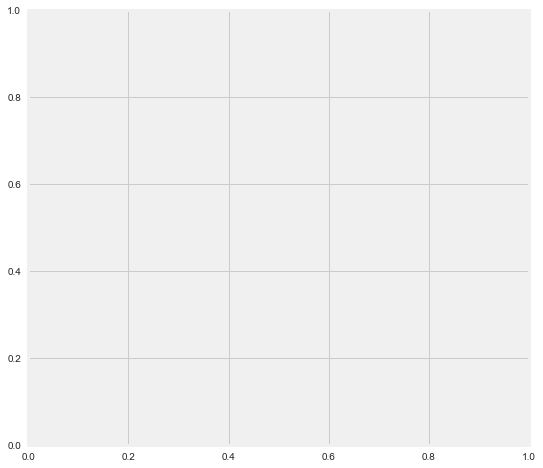

In [24]:
# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

#
# TRYING TO TRAIN ON TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red']
c2 = ['blue','red']

Y_g1g4_test = list(X_g1g4_test['positive'])

# separate the test set into viruses (square) and bacteria (round)
X_g1g4_test_v = X_g1g4_test[X_g1g4_test['pathogenic_green']==True]
X_g1g4_test_b = X_g1g4_test[X_g1g4_test['pathogenic_green']==False]

# separate the training set into viruses (square) and bacteria (round)
X_combo_v = X_combo[X_combo['pathogenic_green']==True]
X_combo_b = X_combo[X_combo['pathogenic_green']==False]

# identify polymicrobial cases
mult_pathos1 = pd.Series(Counter(list(X_g1g4_test[X_g1g4_test['positive']]['patient']) 
                                 + list(X_combo[X_combo['positive']]['patient'])))
mp1 = mult_pathos1[mult_pathos1>1]
mp =  list(mp1.index) # patients with multiple pathogens identified by clinical microbiology
sp = [i for i in mult_pathos1.index if i not in mp]  # patients with single pathogens

fig, ax = plt.subplots(figsize=[8,8], facecolor='white')
ax.set_axis_bgcolor('white')
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')

plt.scatter(X_g1g4_test_v['DNAvalue'] + X_g1g4_test_v['RNAvalue'],X_g1g4_test_v['score'],
            edgecolor=[c[int(X_g1g4_test_v.loc[i]['positive'])] 
                       if X_g1g4_test_v.loc[i]['patient'] in (sp) 
                       or c[int(X_g1g4_test_v.loc[i]['positive'])] == 'blue' 
                       else 'darkred' for i in X_g1g4_test_v.index],
            s=[max(i*600,10) for i in X_g1g4_test_v['score']],
            linewidth='1.2',
            marker='s',
            facecolor=[c2[int(X_g1g4_test_v.iloc[i]['positive'])] if X_g1g4_test_v.iloc[i]['score'] 
                       > PROBABILITY_THRESHOLD else 'none' for i in range(len(X_g1g4_test_v)) ],
            alpha=.7) 

plt.scatter(X_combo_v['DNAvalue']+X_combo_v['RNAvalue'],X_combo_v['score'],
            edgecolor=[c[int(X_combo_v.loc[i]['positive'])] 
                       if X_combo_v.loc[i]['patient'] in (sp) 
                       or c[int(X_combo_v.loc[i]['positive'])] == 'blue' 
                       else 'darkred' for i in X_combo_v.index],
            s=[max(i*600,10) for i in X_combo_v['score']],
            linewidth='1.2',
            marker='s',
            facecolor=[c2[int(X_combo_v.iloc[i]['positive'])] if X_combo_v.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(X_combo_v['positive']))],
            alpha=.7)

plt.scatter(X_g1g4_test_b['DNAvalue']+X_g1g4_test_b['RNAvalue'], X_g1g4_test_b['score'],
            edgecolor=[c[int(X_g1g4_test_b.loc[i]['positive'])] 
                       if X_g1g4_test_b.loc[i]['patient'] in (sp) 
                       or c[int(X_g1g4_test_b.loc[i]['positive'])] == 'blue' 
                       else 'darkred' for i in X_g1g4_test_b.index],
            s=[max(i*600,10) for i in X_g1g4_test_b['score']],
            linewidth='1.2',
            facecolor=[c[int(X_g1g4_test_b.iloc[i]['positive'])] if X_g1g4_test_b.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(X_g1g4_test_b)) ],
            alpha=.7) 

plt.scatter(X_combo_b['DNAvalue']+X_combo_b['RNAvalue'],X_combo_b['score'],
            edgecolor=[c[int(X_combo_b.loc[i]['positive'])] 
                       if X_combo_b.loc[i]['patient'] in (sp) 
                       or c[int(X_combo_b.loc[i]['positive'])] == 'blue'  
                       else 'darkred' for i in X_combo_b.index],
            s=[max(i*600,10) for i in X_combo_b['score']],
            linewidth='1.2',
            facecolor=[c2[int(X_combo_b.iloc[i]['positive'])] if X_combo_b.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'none' for i in range(len(X_combo_b['positive'])) ],
            alpha=.7)

plt.axhline(y=PROBABILITY_THRESHOLD, color='firebrick', linestyle='--',lw=1)
plt.yticks(np.arange(0, 1.1, .1))
plt.xlabel("log(DNA rpM) + log(RNA rpM)")
plt.ylabel("LRM Probability")
ax.grid(linestyle='-', linewidth='0.25', color='#A9A9A9')
plt.savefig('./output/' + output_directory + '/Figure2C_v2_virbac.pdf',transparent=True)
plt.show()


#### LRM ROC Plot (Publication version)

This plot puts together the following:
1. The mean ROC curve and standard deviation for 1000 rounds of 70/30 training/test sub-split in the Training Set
2. The ROC curve for LOPO-CV in the training set
3. The ROC curve for validation with the test set.

AttributeError: 'AxesSubplot' object has no attribute 'set_axis_bgcolor'

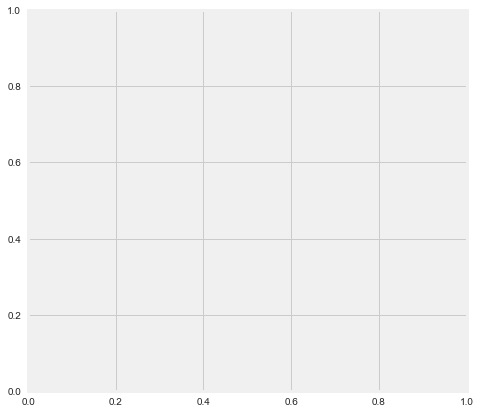

In [25]:
c = ['blue','red']

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
ax.set_axis_bgcolor('white')
plt.rcParams['axes.facecolor'] = '#f0f0f0'

# 1000 rounds of 70%/30% train/test ROC Curve

mean_tpr_iterative = np.mean(tprs_iterative, axis=0)
mean_tpr_iterative[-1] = 1.0
mean_auc_iterative = auc(mean_fpr_iterative, mean_tpr_iterative)
std_auc_iterative = np.std(aucs_iterative)
plt.plot(mean_fpr_iterative, 
         mean_tpr_iterative, 
         color='grey',
         label=r'Derivation LOO-CV AUC = %0.2f $\pm$ %0.2f' % (mean_auc_iterative, 
                                                               std_auc_iterative),
         lw=3, alpha=.7)
std_tpr_iterative = np.std(tprs_iterative, axis=0)
tprs_iterative_upper = np.minimum(mean_tpr_iterative + std_tpr_iterative, 1)
tprs_iterative_lower = np.maximum(mean_tpr_iterative - std_tpr_iterative, 0)
plt.fill_between(mean_fpr_iterative, 
                 tprs_iterative_lower, 
                 tprs_iterative_upper, 
                 color='lightgrey', 
                 alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
xlim([-0.05, 1.05])
ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# LOPO-CV ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(list(X_g1g4_train['positive']),
                                         list(X_g1g4_train['score']), pos_label=1)    
ci = pathogen_functions.get_CI([int(i) for i in list(X_g1g4_train['positive'])], 
                               list(X_g1g4_train['score']), 1000)
plt.plot(fpr, tpr, 
         color='blue',
         lw=3, 
         alpha=.8, 
         label = 'Derivation LOPO-CV AUC = %0.2f (%0.2f - %0.2f)' % (metrics.roc_auc_score(
             list(X_g1g4_train['positive']),list(X_g1g4_train['score'])),ci[0],ci[1]))

# Test set ROC Curve

fpr, tpr, thresholds = metrics.roc_curve(list(X_g1g4_test['positive']), 
                                         list(X_g1g4_test['score']), pos_label=1)    
ci = pathogen_functions.get_CI([int(i) for i in list(X_g1g4_test['positive'])], 
                               list(X_g1g4_test['score']), 1000)
plt.plot(fpr, tpr, 
         color='green',
         lw=3, 
         alpha=.8, 
         label = 'Validation AUC = %0.2f (%0.2f - %.2f)' % (metrics.roc_auc_score(
             list(X_g1g4_test['positive']),list(X_g1g4_test['score'])),ci[0],ci[1]))

# visual aspects of the plot
ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')
l = plt.legend(bbox_to_anchor=(.85, -.3),loc=4)
l.get_frame().set_facecolor('white')
l.get_frame().set_edgecolor('white')

plt.savefig('./output/' + output_directory + '/Figure2C.pdf', transparent = True,bbox_inches='tight')
plt.show()


# Return stats on the content of the Group 1 + Group 4 training set
print("\nNumber of \'Pathogens\' in Training Set: " + 
      str(Counter(list(X_combo['positive']))[True]))
print("Number of \'Commensals\' in Training Set: " + 
      str(Counter(list(X_combo['positive']))[False]))
print("Percentage of microbes used for training that are \'Pathogens\': " + 
      str(Counter(list(X_combo['positive']))[True]/X_combo.shape[0]))

print("\nNumber of \'Pathogens\' in Test Set: " + 
      str(Counter(list(X_g1g4_test['positive']))[True]))
print("Number of \'Commensals\'in Test Set: " + 
      str(Counter(list(X_g1g4_test['positive']))[False]))
print("Percentage of microbes used for TEST that are \'Pathogens\': " + 
      str(Counter(list(X_combo['positive']))[True]/X_combo.shape[0]))


#### Save microbe score results in .csv file for use in R script

In [26]:
# Compute MAX PATIENT SCORES for groups 2 and 3...
# this will be used as input to the R script for microbial arm of the combo score

for i in set(X_g1g4_test['patient']):
    patient_max_scores[i] = max(X_g1g4_test[X_g1g4_test['patient'] == i]['score'])

for i in set(X_g2['patient']):
    patient_max_scores[i] = max(X_g2[X_g2['patient'] == i]['score'])
    
for i in set(X_g3['patient']):
    patient_max_scores[i] = max(X_g3[X_g3['patient'] == i]['score'])
    
df = pd.DataFrame.from_dict(patient_max_scores, orient='index')
df.index = [i.split('.')[0] for i in df.index]

grp = []
for i in df.index:
    grp.append(int(metadata[metadata['RNAfilename']==i]['effective_group']))

df['color'] = grp

#write the scores to .csv file so they can be read as "microbe scores" into the R script
df.to_csv('./output/' + output_directory + '/patient_microbe_scores.csv')  

# write microbe predictions to .csv file 
patient_by_microbe_predicted_g1g4_test.to_csv('./output/' + 
                                              output_directory + 
                                              "/LRpred_G1G4_test.csv")
patient_by_microbe_predicted_g2.to_csv('./output/' + 
                                       output_directory + 
                                       '/LRpred_G2.csv')
patient_by_microbe_predicted_g3.to_csv('./output/' + 
                                       output_directory + 
                                       '/LRpred_G3.csv')

KeyError: 'score'

### Generate Supplemental Tables of Microbe Data (ie Table S3B)


In [27]:
X_withscores = X_g2 #pd.concat([X_g1g4_train,X_g1g4_test,X_g2,X_g3])
A = X_withscores[X_withscores['score'] > PROBABILITY_THRESHOLD].sort_values(by='patient')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 1]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                        output_directory + 
                                        '/group1POS.microbestats.csv')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 2]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                    output_directory + 
                                    '/group2POS.microbestats.csv')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 3]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                    output_directory + 
                                    '/group3POS.microbestats.csv')
A[[i.split(".")[0] in list(metadata[metadata['effective_group'] == 4]['RNAfilename']) for 
   i in list(A['patient'])]].to_csv('./output/' + 
                                    output_directory + 
                                    '/group4POS.microbestats.csv')

KeyError: 'score'

In [22]:
X_withscores = X #X_g2 #pd.concat([X_g1g4_train,X_g1g4_test,X_g2,X_g3])

# add the clinical values    
X_withscores['Clin+'] = ['Y' if i else 'N' for i in list(X_withscores['positive'])]

# add one to ranks to make them more standard notation
X_withscores['ranks'] = X_withscores['ranks'] + 1

# append LRM predictions 
X_withscores['LRM+'] = ['Y' if i > PROBABILITY_THRESHOLD else 'N' for 
                        i in list(X_withscores['score'])]


# append the RBM predictions
all_RBM = pd.concat([rbm_g1,rbm_g2,rbm_g3,rbm_g4])
rbm_pos = []
for i in X_withscores.index:
    p = X_withscores.loc[i]['patient']
    m = X_withscores.loc[i]['microbe']#_genus']
    a = list(all_RBM[all_RBM['patient']==p]['microbe'])#_genus'])
    if m in a:
        rbm_pos.append('Y')
    else:
        rbm_pos.append('N')
X_withscores['RBM+'] = rbm_pos    

X_withscores['Study ID'] = [i.split('-')[0] for i in list(X_withscores['patient'])]
X_withscores['keep'] = [list(X_withscores.loc[i][['Clin+','LRM+','RBM+']]).count('Y') > 0 for 
                        i in X_withscores.index]

lrti_cat_dict = {1:'LRTI+C/+M', 2:'LRTI+C',3:'unk-LRTI',4:'no-LRTI',5:'water'}
X_withscores['LRTI Category'] = [lrti_cat_dict[i] for i in list(X_withscores['groupID'])]        
X_withscores.sort_values(by='Study ID',inplace=True)
X_withscores.head(n=10)

,RNAvalue,DNAvalue,nrnt,groupID,ranks,microbe,patient,microbe_genus,nt_Z_rna,nt_Z_dna,...,pathogenic_green,pathogenic_darkblue,positive,score,Clin+,LRM+,RBM+,Study ID,keep,LRTI Category
0,4.281794,0,1,1.0,1,Streptococcus pneumoniae,chrf_rna_0002_s2.csv,1301,36.4,0,...,False,False,True,1.207735e-01,Y,N,Y,chrf_rna_0002_s2.csv,True,LRTI+C/+M
1,0.100371,0,1,1.0,1,Thermaerobacter marianensis,chrf_rna_0003_s3.csv,73918,2.8,0,...,False,True,False,1.323501e-02,N,N,N,chrf_rna_0003_s3.csv,False,LRTI+C/+M
26,0.041393,0,1,1.0,25,Candidatus Nitrosoglobus terrae,chrf_rna_0004_s4.csv,1980513,3.4,0,...,False,True,False,2.468432e-13,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
25,0.064458,0,1,1.0,24,Thermomicrobium roseum,chrf_rna_0004_s4.csv,499,1.7,0,...,False,True,False,6.836447e-13,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
24,0.079181,0,1,1.0,23,Acholeplasma laidlawii,chrf_rna_0004_s4.csv,2147,43.6,0,...,False,True,False,1.902031e-12,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
23,0.107210,0,1,1.0,22,Meiothermus ruber,chrf_rna_0004_s4.csv,65551,1.3,0,...,False,True,False,5.253516e-12,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
22,0.120574,0,1,1.0,21,Proteiniphilum saccharofermentans,chrf_rna_0004_s4.csv,294702,12.3,0,...,False,True,False,1.462714e-11,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
21,0.158362,0,1,1.0,20,Alloactinosynnema sp. L-07,chrf_rna_0004_s4.csv,674734,1.1,0,...,False,True,False,4.018629e-11,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
20,0.214844,0,1,1.0,19,Sphaerobacter thermophilus,chrf_rna_0004_s4.csv,2056,1.4,0,...,False,True,False,1.092859e-10,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M
19,0.283301,0,1,1.0,18,Peptoniphilus sp. ING2-D1G,chrf_rna_0004_s4.csv,162289,1.1,0,...,False,True,False,2.952645e-10,N,N,N,chrf_rna_0004_s4.csv,False,LRTI+C/+M


In [23]:
# This finalizes the output for TableS3B (Publication version)

table3B = X_withscores[X_withscores['keep']][['Study ID',
                                              'LRTI Category', 
                                              'microbe', 
                                              'Clin+', 
                                              'LRM+', 
                                              'RBM+',
                                              'RNAvalue',
                                              'DNAvalue',
                                              'ranks',
                                              'pathogenic_red',
                                              'pathogenic_green',
                                              'score',
                                              'nt_Z_rna',
                                              'nt_Z_dna']]

adding_to_df = []
for i in set(list(X_withscores['Study ID'])):
    if i not in list(table3B['Study ID']):
        adding_to_df.append(
            [i, str(list(X_withscores[X_withscores['Study ID']==i]['LRTI Category'])[0])] + 
            [None for i in range(12)])
        
df2 = pd.DataFrame(adding_to_df, columns=table3B.columns)
x = table3B.append(df2)
table3B = x

table3B.columns = ['Study ID',
                   'LRTI Category', 
                   'Microbe', 
                   'Clin+', 
                   'LRM+', 
                   'RBM+',
                   'log10( RNA-seq genus rpM )',
                   'log10( DNA-seq genus rpM )',
                   'Rank','Respiratory Pathogen?',
                   'Virus?',
                   'LRM Score',
                   'RNA Z-score',
                   'DNA Z-score']

table3B.sort_values(by=['Study ID','Rank'], inplace=True)
table3B_1 = table3B[table3B['LRTI Category'] == 'LRTI+C/+M']
table3B_2 = table3B[table3B['LRTI Category'] == 'LRTI+C']
table3B_3 = table3B[table3B['LRTI Category'] == 'unk-LRTI']
table3B_4 = table3B[table3B['LRTI Category'] == 'no-LRTI']

t3 = pd.concat([table3B_1,table3B_2,table3B_4,table3B_3])
t3.tail(n=10)
t3.to_csv('./output/' + output_directory + '/TableS3Bfinal.csv',index=False)

## Preliminary version of Figure 3 - combining all methods of pathogen prediction

This is used to rapidly assess the microbial predictions, however it DID NOT end up in the manuscript due to the difficulty protraying the take-home message.

    index                       microbe microbe_genus                patient
0       0      Streptococcus pneumoniae          1301   chrf_rna_0002_s2.csv
1       1        Neisseria meningitidis           482  chrf_rna_0063_s63.csv
2       2      Streptococcus pneumoniae          1301  chrf_rna_0064_s64.csv
3       3           Salmonella enterica           590  chrf_rna_0015_s15.csv
4       4           Bacillus velezensis          1386  chrf_rna_0028_s28.csv
5       5     Elizabethkingia anophelis        308865  chrf_rna_0029_s29.csv
6       6              Escherichia coli           561  chrf_rna_0052_s52.csv
7       0           Salmonella enterica           590   chrf_rna_0007_s7.csv
8       1           Salmonella enterica           590  chrf_rna_0068_s68.csv
9       2           Salmonella enterica           590  chrf_rna_0032_s32.csv
10      3           Salmonella enterica           590  chrf_rna_0018_s18.csv
11      4           Salmonella enterica           590  chrf_rna_0042_s42.csv

nan
chrf_rna_0043_s43.report.csv
nan
chrf_rna_0044_s44.report.csv
nan
chrf_rna_0045_s45.report.csv
nan
chrf_rna_0046_s46.report.csv
nan
chrf_rna_0047_s47.report.csv
nan
chrf_rna_0048_s48.report.csv
nan
chrf_rna_0050_s50.report.csv
Streptococcus pneumoniae
Streptococcus pneumoniae
indise Try
0
chrf_rna_0051_s51.report.csv
Streptococcus pneumoniae
Streptococcus pneumoniae
indise Try
0
chrf_rna_0052_s52.report.csv
Escherichia coli
Escherichia coli
indise Try
3
chrf_rna_0053_s53.report.csv
nan
chrf_rna_0054_s54.report.csv
nan
chrf_rna_0055_s55.report.csv
nan
chrf_rna_0056_s56.report.csv
nan
chrf_rna_0057_s57.report.csv
nan
chrf_rna_0058_s58.report.csv
nan
chrf_rna_0059_s59.report.csv
nan
chrf_rna_0060_s60.report.csv
nan
chrf_rna_0061_s61.report.csv
Streptococcus pneumoniae
Streptococcus pneumoniae
indise Try
0
chrf_rna_0062_s62.report.csv
Streptococcus pneumoniae
Streptococcus pneumoniae
indise Try
0
chrf_rna_0063_s63.report.csv
Neisseria meningitidis
Neisseria meningitidis
indise Try
3
ch

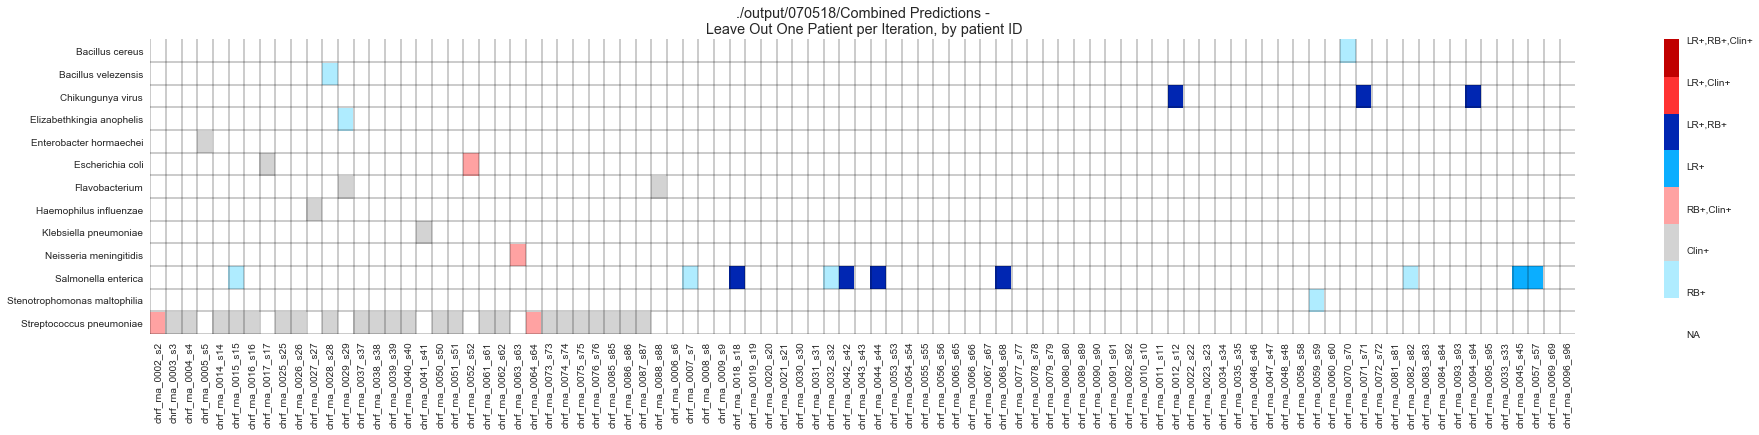

In [24]:

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

gcombos = []

# TRYING TO CREATE COMBO HEATMAP THAT WILL TAKE IN THE INPUTS FROM ALL G1, G4, G2/3 and output the color-coded heatmap
# NOVEMBER 27

def create_prediction_heatmap_combo_overlap(input_rbm_data, input_lr_data, original_matrix, filename, groupID, true_classification, output_directory, metadata, training_sample_names, output_filename, print_output = False, collapse=True):

    print(input_rbm_data)
    print(input_lr_data)
    input_rbm_data.to_csv('./output/' + output_directory + '/TableS6A.csv')
    input_lr_data.to_csv('./output/' + output_directory + '/TableS6B.csv')

    # my original colors - using color to indicate group, shade to indicate clin +
    #colors = ['white','deepskyblue','lightgrey','blue','yellow','orange','gold','red']
    #colors = ['white','#2FD2FF','lightgrey','#2666C7','#FFFC6F','#FF7E70','#FFD700','#DA2727']

    # new colors - using shade to indicate group, color to indicate clin +
    # WHITE, RB only (light blue), clin only (light grey), RB + Clin (light red), LR only (med blue), LR + RM (dark blue), LR + Clin (med red), LR + RB + Clin (dark red)
    #colors = ['white','#819BFC','lightgrey','#FFABAB','#2752F3','#0026B2','#F30B0B','#AE0000']
    colors = ['white','#AFECFF','lightgrey','#FFA2A2','#0BAEFF','#0026B2','#FF3232','#C00000'] # trying to make the above colors more distinct

    CustomCmap = matplotlib.colors.ListedColormap(colors)
    yay_v = 0

    d = pd.DataFrame(0, index=np.arange(len(set(input_rbm_data['microbe']))), columns=[i.split('.')[0].lower()+'.report.csv' for i in list(set(original_matrix['patient']))])
    d.index = set(input_rbm_data['microbe'])


    #loop through every patient and create a new column for each patient
    #add all group 1s
    g1s_train = []
    g1s_test = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 1:
                if(i.lower()+'.report.csv' in training_sample_names):
                    g1s_train.append(i.lower()+'.report.csv')
                else:
                    g1s_test.append(i.lower()+'.report.csv')
                #g1s.append(i+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 4s
    g4s_train = []
    g4s_test = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 4:
                if(i.lower()+'.report.csv' in training_sample_names):
                    g4s_train.append(i.lower()+'.report.csv')
                else:
                    g4s_test.append(i.lower()+'.report.csv')
                #g4s.append(i+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 2s
    g2s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 2:
                g2s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]
    #add all group 3s
    g3s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 3:
                g3s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]

    #add all group 5s
    g5s = []
    for i in true_classification.index:
        if 'RNA' in i:
            if true_classification.loc[i]['effective_group'] == 5:
                g5s.append(i.lower()+'.report.csv')
                if i.lower() + '.report.csv' not in list(d.columns):   #if patient not in heatmap, add it.
                    print('HIIIIII')
                    d[i.lower() + '.report.csv'] = [0 for j in range(len(d.index))]

    print(g1s_test)
    print(g2s)
    print(g3s)
    print(g4s_test)
    print(g5s)


    #print(metadata.head())
    #print(input_rbm_data['patient'].head())
    #print(metadata[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0])
    
    # ADD VALUES FOR RB method
    for i in input_rbm_data.index:
        d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] = 1
        orgs = metadata[metadata['sample_name_RNA'] == input_rbm_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]
        #print(orgs)
        if(type(orgs) == type('string')):
            if input_rbm_data.iloc[i]['microbe'] in orgs.split(','):
                yay_v += 1
                d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] = d[input_rbm_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_rbm_data.iloc[i]['microbe']] + 2

    # ADD VALUES FOR LR method
    for i in input_lr_data.index:

        try:
            print(d.columns)
            print(input_lr_data.iloc[i]['patient'])
            print(input_lr_data.iloc[i]['microbe'])
            d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] + 4   #try to just add to existing values
        except:
            #NEED TO ADD THE ROW
            new_index = [ v for v in d.index] + [input_lr_data.iloc[i]['microbe']]
            d.loc[len(d)]=[0 for i in range(len(d.columns))]
            d.index = new_index
            d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = 4   # if the value has not existed before, add to the dataframe

        orgs = metadata[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]   # loop through all the organisms
        if(type(orgs) == type('string')):
            if input_lr_data.iloc[i]['microbe'] in orgs.split(','):
                yay_v += 1
                print(d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']])
                if d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] not in [3,7]:  # if the organism is confirmed, but has not previously been clinically confirmed then...add clinical to it
                    d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] = d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][input_lr_data.iloc[i]['microbe']] + 2

    # LOOP THROUGH AND ADD CLINICAL GENERA
    print("???")
    print(len(set(input_lr_data.index)))
    print(metadata.shape)

    for i in metadata.index:#input_lr_data.index:
        index = metadata.loc[i]['sample_name_RNA'].lower()+'.report.csv'
        print(index)
        print(metadata.loc[i]['organism'])
        orgs = metadata.loc[i]['organism']#[metadata['sample_name_RNA'] == input_lr_data.iloc[i]['patient'].split('.')[0].upper()]['organism'].iloc[0]
        if(type(orgs) == type('string')):
            #print(input_lr_data.iloc[i]['patient'])
            #print(orgs)
            '''
            for o in orgs.split(','):
                #list_of_species = list(set(input_lr_data.loc[input_lr_data['microbe_genus']==o]['microbe']).union(set(input_lr_data.loc[input_lr_data['microbe_genus']==o]['microbe'])))
                list_of_species = list(set(input_lr_data.loc[input_lr_data['microbe']==o]['microbe']).union(set(input_lr_data.loc[input_lr_data['microbe']==o]['microbe'])))
                print(list_of_species)
                a_species_was_found = False
                for s in list_of_species:
                    if not a_species_was_found:
                        try:
                            if d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][s] > 0:
                                a_species_was_found = True
                        except:
                            continue

                #print(a_species_was_found)

                if not a_species_was_found:
                    if sum([int(o == v ) for v in  d.index]) > 0:
                        print(o)
                        print(i)
                        print(input_lr_data.head())
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][o] = 2
                    else:
                        new_index = [ v for v in d.index] + [o]
                        d.loc[len(d)]=[0 for i in range(len(d.columns))]

                        d.index = new_index
                        d[input_lr_data.iloc[i]['patient'].split('.')[0] + '.report.csv'][o] = 2

            '''
            for o in orgs.split(','):
                print(o)
                try:
                    print('indise Try')
                    print(d[index][o])
                    if d[index][o] > 0:
                        a_species_was_found = True
                    else:
                        d[index][o] = 2
                except:
                    print('in except')
                    new_index = [ v for v in d.index] + [o]
                    d.loc[len(d)]=[0 for i in range(len(d.columns))]
                    d.index = new_index
                    d[index][o] = 2




    gcombos = g1s_train + g1s_test + g4s_train +  g4s_test + g2s + g3s + g5s

    d = d[gcombos] # this sorts the columns in order of [group1] [group4]

    #reset names to remove .report.csv notation
    new_col_names = []
    for i in d.columns:
        new_col_names.append(i.split('.')[0])
    d.columns = new_col_names




    # Apply some collapsing for the indices
    if(collapse):
        strep_viridans_group = ['Streptococcus pseudopneumoniae ( 257758 )','Streptococcus sp. VT 162 ( 1419814 )',
                                'Streptococcus salivarius ( 1304 )','Streptococcus mitis ( 28037 )',
                                'Streptococcus pseudopneumoniae ( 257758 )','Streptococcus anginosus ( 1328 )']
        strep_preprocessed_names = []
        print(d.index)
        for i in d.index:
            if(i in strep_viridans_group):
                strep_preprocessed_names.append('Streptococci viridans Group ( XXX )')
            elif('coronavirus' in i):
                strep_preprocessed_names.append('Human coronavirus species ( XXX )')
            else:
                strep_preprocessed_names.append(i)  # strep pneumo and strep genera (clinical) will be merged

        d.index = strep_preprocessed_names
        first_values = [' '.join(i.split(' ')[0:-4]) if i.count(' ') > 3 else ' '.join(i.split(' ')[0:-3]) for i in d.index]
        d.index = first_values


        for j in d.columns:
            for k in set(first_values):
                #print(k)
                l = list(d[j][d.index==k])
                #print(l)
                if 2 in l and 3 in l:
                    # this is bad - it will collapse incorrectly and appear the BM and LR matched (score = 5),
                    # when in reality it was a collapse of RB+Clin (3) and Clin+ (3) again - need to modify the cases post-hoc.
                    #print([3] + [0 for i in range(len(l)-1)])
                    d[j][d.index==k] = [3] + [0 for i in range(len(l)-1)]





        d = d.groupby(d.index).sum()

        post_mod_index = []  # MODIFICATIONS TO UPDATE NAME OF STREP AND STAPH TO BE CLEAR
        for i in d.index:
            if(i == 'Streptococcus'):
                post_mod_index.append('Streptococcus pneumoniae')
            elif(i == 'Staphylococcus'):
                post_mod_index.append('Staphylococcus aureus')
            elif(i == 'Human respiratory syncytial'):
                post_mod_index.append('Human RSV')
            else:
                post_mod_index.append(i)

        d.index = post_mod_index




    # sort the indices by alphabetical order
    new_d = d.sort_index(axis=0)
    d = new_d

    #new_columns = ['-'.join(c.split('-')[0:2]) for c in d.columns]
    #new_cols_temp = ['TA-' + str(c.split('-')[1]) for c in d.columns]  #convert names to TA-XXX notation
    #new_columns = [i[0:6] for i in new_cols_temp]  #get rid of TRNA from the one sample that has weird naming convention
    #print(new_columns)
    #d.columns = new_columns




    fig_height = (d.shape[0]/4.8)*2
    #fig_width = d.shape[1]/4.8
    fig_width = (d.shape[1]/6.4)*2

    #d.to_csv('LRcombo.csv')

    if print_output:
        print(d.head())

    #colors = ['white','#4AA2B6','lightgrey','#04819E','#69DE56','#F93846','#1DD300','#F90012']
    #ordered_colors = ['white','lightgrey','deepskyblue','blue','yellow','gold','orange','red']

    cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))


    plt.figure(figsize=(fig_width,fig_height))
    #ax = sns.heatmap(d,cmap=CustomCmap,vmin=0,vmax=7,cbar=False)
    ax = sns.heatmap(d,cmap=cmap,vmin=0,vmax=7)#,cbar=False)
    ax.hlines([i for i in range(len(d.index))], *ax.get_xlim(),lw=.4)
    ax.vlines([i for i in range(len(d.columns))], *ax.get_ylim(),lw=.4)
    ax.tick_params(labelsize=10)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([i for i in range(len(colors))])
    colorbar.set_ticks([0,2,1,3,4,6,5,7])
    colorbar.set_ticklabels(['NA','Clin+','RB+','RB+,Clin+','LR+','LR+,Clin+','LR+,RB+','LR+,RB+,Clin+'])
    #colorbar.set_ticklabels(['NA','RB+','Clin+','RB+,Clin+','LR+','LR+,RB+','LR+,Clin+','LR+,RB+,Clin+'])

    plt.title( filename + ", by patient ID")
    plt.savefig('./output/' + output_directory + '/' + output_filename , bbox_inches='tight')

    return d



lr_results = pd.concat([ 
                        patient_by_microbe_predicted_g2]) #,patient_by_microbe_predicted_g4_test, 
lr_results.reset_index(inplace=True)
c = pd.concat([rbm_g1,rbm_g4,rbm_g2,rbm_g3])
c.reset_index(inplace=True)

X_full = pd.concat([X_g1,X_g4,X_g2,X_g3])

# this representation enables easy viewing of the overlap btwn clinical and predicted results
# unfortunately, the published TableS2 does not highlight this aspect of the data as well, 
# so I am maintaining this graphic here.
#
d = create_prediction_heatmap_combo_overlap(c,lr_results,X_full, 
                                            './output/' +  output_directory + 
                                              '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                               [1,4,2,3],
                                                               true_classification, 
                                                               output_directory, 
                                                               metadata, 
                                                               training_sample_names,
                                                               'FigureS3_TrainTest.pdf', 
                                                               print_output = False, 
                                                               collapse=False)

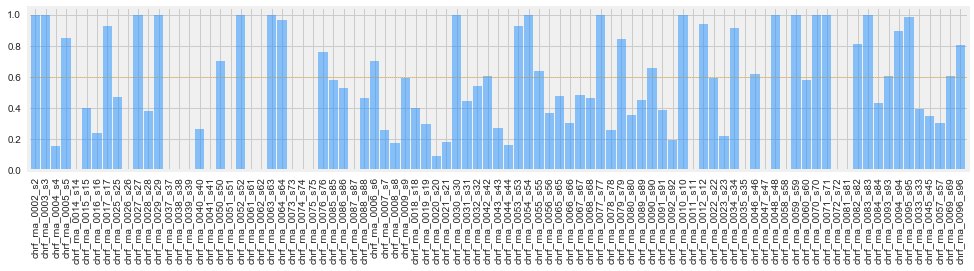

In [34]:
plt.figure(figsize=(15,3))
rna_div_plot = pd.Series(RNA_diversity).loc[list(d.columns)].plot(kind='bar', color='dodgerblue', width=.9, alpha = .5)
#dna_div_plot = pd.Series(DNA_diversity).loc[list(d.columns)].plot(kind='bar', color='green', width=.9, alpha = .5)
plt.axhline(y=.6, linestyle=':', lw=.75, color='orange')
plt.savefig('./output/' + output_directory + '/rna_div_barplot.pdf' , bbox_inches='tight')


[]


KeyError: "None of [['chrf_rna_0002_s2', 'chrf_rna_0003_s3', 'chrf_rna_0004_s4', 'chrf_rna_0005_s5', 'chrf_rna_0014_s14', 'chrf_rna_0015_s15', 'chrf_rna_0016_s16', 'chrf_rna_0017_s17', 'chrf_rna_0025_s25', 'chrf_rna_0026_s26', 'chrf_rna_0027_s27', 'chrf_rna_0028_s28', 'chrf_rna_0029_s29', 'chrf_rna_0037_s37', 'chrf_rna_0038_s38', 'chrf_rna_0039_s39', 'chrf_rna_0040_s40', 'chrf_rna_0041_s41', 'chrf_rna_0050_s50', 'chrf_rna_0051_s51', 'chrf_rna_0052_s52', 'chrf_rna_0061_s61', 'chrf_rna_0062_s62', 'chrf_rna_0063_s63', 'chrf_rna_0064_s64', 'chrf_rna_0073_s73', 'chrf_rna_0074_s74', 'chrf_rna_0075_s75', 'chrf_rna_0076_s76', 'chrf_rna_0085_s85', 'chrf_rna_0086_s86', 'chrf_rna_0087_s87', 'chrf_rna_0088_s88', 'chrf_rna_0006_s6', 'chrf_rna_0007_s7', 'chrf_rna_0008_s8', 'chrf_rna_0009_s9', 'chrf_rna_0018_s18', 'chrf_rna_0019_s19', 'chrf_rna_0020_s20', 'chrf_rna_0021_s21', 'chrf_rna_0030_s30', 'chrf_rna_0031_s31', 'chrf_rna_0032_s32', 'chrf_rna_0042_s42', 'chrf_rna_0043_s43', 'chrf_rna_0044_s44', 'chrf_rna_0053_s53', 'chrf_rna_0054_s54', 'chrf_rna_0055_s55', 'chrf_rna_0056_s56', 'chrf_rna_0065_s65', 'chrf_rna_0066_s66', 'chrf_rna_0067_s67', 'chrf_rna_0068_s68', 'chrf_rna_0077_s77', 'chrf_rna_0078_s78', 'chrf_rna_0079_s79', 'chrf_rna_0080_s80', 'chrf_rna_0089_s89', 'chrf_rna_0090_s90', 'chrf_rna_0091_s91', 'chrf_rna_0092_s92', 'chrf_rna_0010_s10', 'chrf_rna_0011_s11', 'chrf_rna_0012_s12', 'chrf_rna_0022_s22', 'chrf_rna_0023_s23', 'chrf_rna_0034_s34', 'chrf_rna_0035_s35', 'chrf_rna_0046_s46', 'chrf_rna_0047_s47', 'chrf_rna_0048_s48', 'chrf_rna_0058_s58', 'chrf_rna_0059_s59', 'chrf_rna_0060_s60', 'chrf_rna_0070_s70', 'chrf_rna_0071_s71', 'chrf_rna_0072_s72', 'chrf_rna_0081_s81', 'chrf_rna_0082_s82', 'chrf_rna_0083_s83', 'chrf_rna_0084_s84', 'chrf_rna_0093_s93', 'chrf_rna_0094_s94', 'chrf_rna_0095_s95', 'chrf_rna_0033_s33', 'chrf_rna_0045_s45', 'chrf_rna_0057_s57', 'chrf_rna_0069_s69', 'chrf_rna_0096_s96']] are in the [index]"

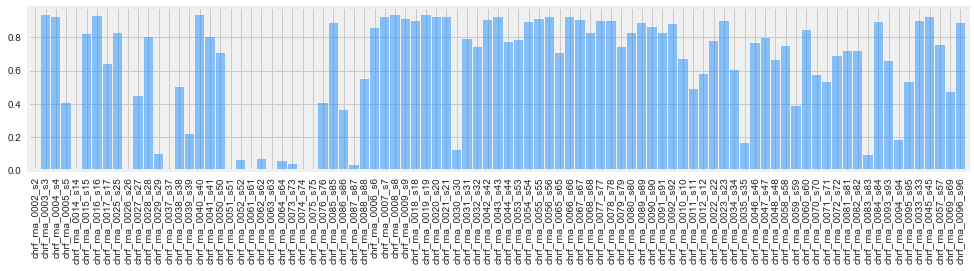

In [30]:
print(gcombos)

plt.figure(figsize=(15,3))
rna_div_plot = pd.Series(RNA_diversity).loc[list(d.columns)].plot(kind='bar', color='dodgerblue', width=.9, alpha = .5)
dna_div_plot = pd.Series(DNA_diversity).loc[list(d.columns)].plot(kind='bar', color='green', width=.9, alpha = .5)
plt.savefig('./output/' + output_directory + '/rna_div_barplot.pdf' , bbox_inches='tight')

plt.figure(figsize=(15,3))
pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).mean(axis=1).loc[list(d.columns)].plot(kind='bar', color='#2e94ad', width=.9, alpha = .8)
plt.savefig('./output/' + output_directory + '/mean_div_barplot.pdf' , bbox_inches='tight')

print(pd.concat([pd.Series(RNA_diversity),pd.Series(DNA_diversity)], axis=1).mean(axis=1).loc[list(d.columns)].loc['chrf_rna_0065_s65'])

In [35]:
#Evaluate how many individuals had microbes identified by each method as compared to the known total number of group 1 patients.
print("Number of patients in Group 1 " + str(len(set(X_g1['patient']))))

print("\nNumber of patients in Group 1 w/ at least 1 pathogens identified by RBM " + 
      str(len(set(rbm_g1['patient']))))
print("Number of microbes identified by RBM in G1: "+ 
      str(len(rbm_g1['microbe'])))

print("\nNumber of patients in Group 1 w/ at least 1 pathogens identified by LR Model " + 
      str(len( set(X_g1['patient']).intersection(
          set(pd.concat([patient_by_microbe_predicted_combo,
                         patient_by_microbe_predicted_g1g4_test])['patient'])))))
print("Number of microbes identified by LR in both G1 and G4: "+ 
      str(len(pd.concat([patient_by_microbe_predicted_combo,
                         patient_by_microbe_predicted_g1g4_test])['microbe'])))

print("\nPatient IDs without a pathogen identified by RBM " + 
      str(set(X_g1['patient']) - set(rbm_g1['patient'])))
print("Patient IDs without a pathogen identified by LR Model " + 
      str(set(X_g1['patient']) - set(pd.concat([patient_by_microbe_predicted_combo,
                                                patient_by_microbe_predicted_g1g4_test])['patient'])))

Number of patients in Group 1 20

Number of patients in Group 1 w/ at least 1 pathogens identified by RBM 7
Number of microbes identified by RBM in G1: 7


NameError: name 'patient_by_microbe_predicted_combo' is not defined

In [36]:
#Evaluate how many individuals had microbes identified by each method as compared to the known total number of group 1 patients.
print("Number of patients in Group 2 " + str(len(set(X_g2['patient']))))
print("\nNumber of patients in Group 2 w/ at least 1 pathogens identified by RBM " + 
      str(len(set(rbm_g2['patient']))))
print("Number of microbes identified by RBM: " + str(len(rbm_g2['patient'])))

print("\nNumber of patients in Group 2 w/ at least 1 pathogens identified by LR Model " + 
      str(len( set(X_g2['patient']).intersection(set(patient_by_microbe_predicted_g2['patient'])))))
print("Number of microbes identified by LR: " + str(len(patient_by_microbe_predicted_g2['patient'])))

print("\nPatient IDs without a pathogen identified by RBM:\n" + 
      '\n'.join(list(set(X_g2['patient']) - set(rbm_g2['patient']))))
print("\nPatient IDs without a pathogen identified by LR Model\n" + 
      '\n'.join(list(set(X_g2['patient']) - set(patient_by_microbe_predicted_g2['patient']))))

Number of patients in Group 2 0

Number of patients in Group 2 w/ at least 1 pathogens identified by RBM 0
Number of microbes identified by RBM: 0

Number of patients in Group 2 w/ at least 1 pathogens identified by LR Model 0
Number of microbes identified by LR: 9

Patient IDs without a pathogen identified by RBM:


Patient IDs without a pathogen identified by LR Model



In [37]:
#OUTPUT per-patient microbe predictions to files
rbm_g1.to_csv('./output/' + output_directory + '/rbm_g1.csv')
rbm_g2.to_csv('./output/' + output_directory + '/rbm_g2.csv')
rbm_g3.to_csv('./output/' + output_directory + '/rbm_g3.csv')
rbm_g4.to_csv('./output/' + output_directory + '/rbm_g4.csv')

patient_by_microbe_predicted_combo.to_csv('./output/' + 
                                          output_directory + 
                                          '/patient_by_microbe_predicted_combo.csv')
patient_by_microbe_predicted_g2.to_csv('./output/' + 
                                       output_directory + 
                                       '/patient_by_microbe_predicted_g2.csv')
patient_by_microbe_predicted_g3.to_csv('./output/' + 
                                       output_directory + 
                                       '/patient_by_microbe_predicted_g3.csv')

NameError: name 'patient_by_microbe_predicted_combo' is not defined

In [38]:
# write the full training and test data matrices to a .csv file so other individuals could replicate the models
X_combo.to_csv("./output/" + output_directory + '/LRTrainingData.csv')
X_g1g4_test.to_csv("./output/" + output_directory + '/LRTestData.csv')

NameError: name 'X_combo' is not defined

## Addressing Outstanding Qs and making modifications specific to publication

**FIGURE S2: Create a 2-part heatmap where part 1 = clinical only, part 2 = RBM/LRM resutls; divided up by sub-component (LRTI+C/+M Deriviation / LRTI+C/+M Validation / no-LRTI Derivation / no-LRTI Validation / LRTI+C / unk-LRTI)**

In [39]:
lr_results = pd.concat([patient_by_microbe_predicted_combo, patient_by_microbe_predicted_g1g4_test, patient_by_microbe_predicted_g2,patient_by_microbe_predicted_g3]) 
lr_results.reset_index(inplace=True)
c = pd.concat([rbm_g1,rbm_g4,rbm_g2,rbm_g3])
c.reset_index(inplace=True)

X_full = pd.concat([X_g1,X_g4,X_g2,X_g3])
d = plotting_functions.create_prediction_heatmap_combo_overlap_update2(c,
                                 lr_results,
                                 X_full, 
                                 './output/' + 
                                 output_directory + 
                                 '/Combined Predictions -\n Leave Out One Patient per Iteration',
                                 [1,4,2,3],
                                 true_classification, 
                                 output_directory,
                                 metadata, 
                                 training_sample_names,
                                 'FigureS3_TrainTest.pdf',
                                 print_output = False, collapse=True)

NameError: name 'patient_by_microbe_predicted_combo' is not defined

**For comparison, create a scatterplot for the water samples!**

Note, the axes of this scatterplot are from 0 to .8. All other scatterplots (ie Figure S1) are on the axis 0 - 5. This emphasizes the fact that water samples had substantially fewer microbial reads. 

In [40]:
dna_water = pd.read_csv('data/' + data_directory + '/water_controls/' + 
                        'direct_water_subtraction_DNA.concordant.csv',index_col=0)
rna_water = pd.read_csv('data/' + data_directory + '/water_controls/' + 
                        'direct_water_subtraction_RNA.concordant.csv',index_col=0)

c = ['blue','red']
water_pathogens = [c[int(i.split(' ')[0] in ' '.join(full_respiratory_microbes_list))] for 
                   i in dna_water.index]

plt.figure(figsize=(6, 6))
plt.scatter(np.log10(rna_water['x']+1),  
                           np.log10(dna_water['x']+1),               
            alpha = .6,
            marker='o',
            s=200,
            edgecolor=water_pathogens, 
            facecolor='none', 
            linewidth='1.2' )

plt.xlim((-.05, 0.8))
plt.ylim((-.05, 0.8))

# annotate the scatterplot points with the microbe name
for n in dna_water.index:
    plt.annotate(n.split(' ')[0], (np.log10(rna_water.loc[n]['x']+1)+.02,  
                               np.log10(dna_water.loc[n]['x']+1)+.04),
                                             fontsize=5, color='grey',rotation=30) 
    
plt.xlabel("log(rpm RNA)")
plt.ylabel("log(rpm DNA)")
plt.title("Scaled rpm Values for concordant\n microbes in water samples")
plt.savefig('./output/' + output_directory + '/Water_Microbes.pdf')

FileNotFoundError: File b'data/060618/water_controls/direct_water_subtraction_DNA.concordant.csv' does not exist

**Are there any LR predictions that weren't in the list of common respiratory pathogens?**

While the LR model does potentially enable the detection of "putative pathogens" that are not in the list of known respiratory pathogens, there were few cases of this in our cohort. 

In [ ]:
# merge all the relevant dataframes of predictions
not_in_list_of_common = pd.concat([X_combo, X_g1g4_test, X_g2, X_g3])  

# report the predictions that were positive by LRM and not in the list of common pathogens (ie pathogenic_red != True)
not_in_list_of_common[not_in_list_of_common['score'] > PROBABILITY_THRESHOLD][not_in_list_of_common[not_in_list_of_common['score'] > PROBABILITY_THRESHOLD]['pathogenic_red'] == False]

**What is the sensitivity and specificity of the RBM and LRM (on the microbe level)**

In [ ]:
# SENSITIVITY AND SPECIFICITY CALCULATIONS -- 3/22

# RBM Performance - combined the derivation and validation sets to report only 
# the overall sens/spec.
print("RBM Overall Performance (for G1 and G4, regardless of Training v. Test Set)")
Xws = X_withscores[X_withscores['LRTI Category'].isin(['LRTI+C/+M','no-LRTI'])]
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws['Clin+'])],
                                  [i == 'Y' for i in list(Xws['RBM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

#a = Xws[Xws['RBM+']=="Y"]
#b = a[a['Clin+']=="N"]
#print(b)




print("\n------------\n")

# PERFOMANCE SEPARATED BY TRAINGING AND TEST SETS
Xws_train = X_withscores[X_withscores['patient'].isin(list(X_g1g4_train['patient']))]
print("Training set size:")
print(Xws_train.shape)
print("Test set size:")
Xws_test = X_withscores[X_withscores['patient'].isin(list(X_g1g4_test['patient']))]
print(Xws_test.shape)

print("\n------------\n")

# RBM Performance - combined the derivation and validation sets to report only 
# the overall sens/spec.
print("RBM training performance")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_train['Clin+'])],
                                  [i == 'Y' for i in list(Xws_train['RBM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))
print("\n")

print("RBM test performance")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_test['Clin+'])],
                                  [i == 'Y' for i in list(Xws_test['RBM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

print("\n------------\n")

# LRM Performance, separated by training and test set
print("\nLRM training performance:")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_train['Clin+'])],
                                  [i == 'Y' for i in list(Xws_train['LRM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

print("\nLRM test performance:")
tn, fp, fn, tp = confusion_matrix([i == 'Y' for i in list(Xws_test['Clin+'])],
                                  [i == 'Y' for i in list(Xws_test['LRM+'])]).ravel()
print("TN : TP : FP : FN = " + str( [tn, tp, fp, fn]))
print("Sensitivity: " + str(tp/(tp+fn)))
print("Specificity: " + str(tn/(tn+fp)))
print("Accuracy:" + str((tp+tn)/(tp + tn + fp + fn)))

print("\nNote: PROBABILITY_THRESHOLD used = " + str(PROBABILITY_THRESHOLD))

#### Proving to myself that the LRM is better than just RNA+DNA rpm

In [ ]:
# set up 4-panel scatter plot
fig, axarr = plt.subplots(2,2, figsize=(16,6), sharey = False, sharex = True)  

# AUC for LRM on test set
# in scatterplot, we should ideally see all blue dots (commensals) with low scores 
# and all red dots (pathogens) with high scores
t = X_g1g4_test
t.sort_values(by='score', inplace=True)
#plt.figure(figsize=(8,3))
axarr[0,0].scatter([i for i in range(len(t.index))], t['score'], color = 
                   ['red' if t.loc[i]['positive'] else 'blue' for i in t.index])
axarr[0,0].annotate("AUC for test set (should be same as what is shown above): " + 
                    str(metrics.roc_auc_score(list(X_g1g4_test['positive']),
                                              list(X_g1g4_test['score']))),
                    xy=(1,.8))
axarr[0,0].set_title('AUC LRM Score, all microbes')
#plt.show()

# AUC for RNA rpm + DNA rpm on test set
# in scatterplot, we should ideally see all blue dots (commensals) with low scores 
# and all red dots (pathogens) with high scores
t['RNA+DNA'] = list(X_g1g4_test['RNAvalue']+X_g1g4_test['DNAvalue'])
t1 = t
t.sort_values(by='RNA+DNA', inplace=True)
axarr[0,1].scatter([i for i in range(len(t.index))], t['RNA+DNA'], 
                   color = ['red' if t.loc[i]['positive'] else 'blue' for i in t.index])
axarr[0,1].annotate("\nAUC for test set using just RNA rpm + DNA rpm: " + 
                    str(metrics.roc_auc_score(list(X_g1g4_test['positive']),
                                              list(X_g1g4_test['RNAvalue']+
                                                   X_g1g4_test['DNAvalue']))),
                    xy=(1,6))
axarr[0,1].set_title('AUC RNA+DNA, all microbes')

# remove all additional microbes (only 1 etiologic pathogen per person)
tpos = t[t['positive']]
tneg = t[t['positive']==False]
t2 = tpos.drop_duplicates(subset=['patient','positive'], keep="last")
t3 = pd.concat([t2,tneg])

# print the change in microbe numbers
print("\noriginal number of total microbes: " + str(t.shape))
print("number of microbes after removing polymicrobial: " + str(t3.shape))

# AUC for LRM Score on test set with only 1 microbe / person
t3.sort_values(by='score',inplace=True)
axarr[1,0].scatter([i for i in range(len(t3.index))], t3['score'], 
                   color = ['red' if t3.loc[i]['positive'] else 'blue' for i in t3.index])
axarr[1,0].annotate("\nAUC for test set using LRM without polymicrobial: "+ 
                    str(metrics.roc_auc_score(list(t3['positive']),list(t3['score']))),
                    xy=(1,.8))
axarr[1,0].set_title('AUC LRM Score, Without polymicrobial')

# AUC for RNA+DNA on test set with only 1 microbe / person
t3.sort_values(by='RNA+DNA',inplace=True)
axarr[1,1].scatter([i for i in range(len(t3.index))], t3['RNA+DNA'], 
                   color = ['red' if t3.loc[i]['positive'] else 'blue' for i in t3.index])
axarr[1,1].annotate("\nAUC for test set using just RNA + DNA without poly: " + 
                    str(metrics.roc_auc_score(list(t3['positive']),
                                              list(t3['RNAvalue']+t3['DNAvalue']))),
                    xy=(1,6))
axarr[1,1].set_title('AUC RNA+DNA, Without polymicrobial')
plt.show()

### Learning Curve Analysis

Is the training set an appropriate size for the logistic regression model?

> "To evaluate the logistic regression model performance as a function of derivation cohort size, learning curves were computed using randomized subsets of microbes from the derivation set (n = 5, 10, 15…165 total training microbes). The training and test mean square error (MSE) were computed along with the AUC for the test set at each iteration. This process was repeated over 25 rounds and the mean learning curve was computed (Figure S5A). The results indicate that the training set has saturated model performance, suggesting adequate sample size for the aforementioned analyses. We note that balanced classes may be of benefit, but are unrealistic given the distribution of pathogens amongst the lung microbiome."

In [ ]:
from sklearn.model_selection import LeaveOneOut
from operator import itemgetter

#
# Generate learning curve and associated performance metrics; save to dataframe 
# for subsequent plotting.
#

# this takes some time, so set False if we don't want this portion of analysis to run.
run_LC = True  

if run_LC:
    
    # Generate the data for the learning curves
    X_combo = pd.concat([X_g1_train,X_g4_train])  # train on both group 1 and group 4 patients
    y_combo = Y_g1_train + Y_g4_train

    # track num iterations w/ only one class present (likely the negative class) in the test set
    oneclasspresent = 0  
    c = ['blue','red']  

    # set variables to track performance across iterations
    full_aucs = {}
    full_accs = {}
    full_patient_aucs = {}
    full_acc_train = {}
    full_auc_train = {}
    full_trainE = {}
    full_testE = {}
    full_trainppE = {}
    full_testppE = {}

    for n_iters in range(25):    # run the full learning curve 25 times, to estimate variance
        print("STARTING NEW LC ITERATION: " + str(n_iters))                  # "progress bar"
        
        # set variables to track performance within each iteration
        aucs_iterative = []
        acc = []
        sens = []
        spec = []
        acc_train = []
        patient_aucs = []
        aucs_iterative_train = []
        trainE = []
        testE = []
        trainppE = []
        testppE = []

        # loop from 1 to 170, to randomly select n*5 = 5 - 170 training samples to use for 
        # the training as this value increases, the performance is expected to improve 
        # and eventually plateau
        for i in range(34):  

            # at lower numbers you may have only 1 class represented (imbalanced classes), 
            # so repeat until you randomly draw... 
            unsuccessful = True            
            
            # ...a set including at least 1 training sample from both "pathogen" and 
            # "commensal" classes
            while unsuccessful == True:    

                try:   # try to randomly select n*5 training samples
                    r = random.sample([j for j in range(len(X_combo.index))], (i+1)*5)     
                except: # if you have exceeded the max number of samples, use all training data
                    r = [j for j in range(len(X_combo.index))]
                
                # create the sub-training set based on sampled indices
                X_train = X_combo.iloc[r][training_variables] 
                y_train = itemgetter(*r)(y_combo)

                X_test = X_g1g4_test[training_variables] # test set is full test set
                y_test = X_g1g4_test['positive']

                # keep looping until you have a success
                if True:
                    try:
                        
                        # create logistic regression model; no regularization
                        lr = linear_model.LogisticRegression(C=1000000) 
                        lr.fit(X_train, y_train)    # fit the logistic regression model

                        # compute training error metrics
                        cm_train = confusion_matrix(y_train, 
                                                    lr.predict(X_train) > PROBABILITY_THRESHOLD)
                        train_predict = lr.predict_proba(X_train)[:,1] > PROBABILITY_THRESHOLD
                        train_error =  sum([(train_predict[j] - int(y_train[j]))**2 for 
                                            j in range(len(y_train))])/len(y_train)
                        trainE.append(train_error)
                        total_train=sum(sum(cm_train))
                        accuracy_train=(cm_train[0,0]+cm_train[1,1])/total_train
                        acc_train.append(accuracy_train)
                        fpr, tpr, thresholds = metrics.roc_curve(y_train, 
                                                                 lr.predict_proba(X_train)[:,1], 
                                                                 pos_label=1)  
                        aucs_iterative_train.append(auc(fpr, tpr))

                        # compute test error metrics
                        test_predict = lr.predict_proba(X_test)[:,1] > PROBABILITY_THRESHOLD
                        test_error =  sum([(test_predict[j] - int(list(y_test)[j]))**2 for 
                                           j in range(len(y_test))])/len(y_test)
                        testE.append(test_error)
                        cm1 = confusion_matrix(y_test, lr.predict(X_test) > PROBABILITY_THRESHOLD)
                        total1=sum(sum(cm1))
                        accuracy1=(cm1[0,0]+cm1[1,1])/total1
                        acc.append(accuracy1)
                        sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
                        sens.append(sensitivity1)
                        specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1]) 
                        spec.append(specificity1)

                        fpr, tpr, thresholds = metrics.roc_curve(y_test, 
                                                                 lr.predict_proba(X_test)[:,1], 
                                                                 pos_label=1)  
                        tprs_iterative.append(interp(mean_fpr_iterative, fpr, tpr))
                        tprs_iterative[-1][0] = 0.0
                        roc_auc = auc(fpr, tpr)
                        aucs_iterative.append(roc_auc)


                        # get the maximum score per patient, use this to calculate AUC for LRTI v. No LRTI prediction
                        X_test_pp = X_g1g4_test
                        X_test_pp['score'] = lr.predict_proba(X_test)[:,1]
                        idx = X_test_pp.groupby(['patient'])['score'].transform(max) == X_test_pp['score'] 
                        X_test_pp2 = X_test_pp[idx] 
                        fpr, tpr, thresholds = metrics.roc_curve(X_test_pp2['groupID']==1, X_test_pp2['score'], pos_label=1) 
                        patient_aucs.append(auc(fpr, tpr))
                        test_pp_error =  sum([(X_test_pp2.iloc[j]['score'] - int(X_test_pp2.iloc[j]['groupID']==1))**2 for 
                                              j in range(len(X_test_pp2.index))])/len(X_test_pp2.index)
                        testppE.append(test_pp_error)

                        X_train_pp = X_combo.iloc[r]
                        X_train_pp['score'] = lr.predict_proba(X_train)[:,1]
                        idx = X_train_pp.groupby(['patient'])['score'].transform(max) == X_train_pp['score'] 
                        X_train_pp2 = X_train_pp[idx] 
                        train_pp_error =  sum([(X_train_pp2.iloc[j]['score'] - int(X_train_pp2.iloc[j]['groupID']==1))**2 for 
                                               j in range(len(X_train_pp2.index))])/len(X_train_pp2.index)
                        trainppE.append(train_pp_error)
                        
                        
                        unsuccessful = False   # successfully reached the end of this iteration of learning curve, so break out of while loop

                    except Exception as e:
                        oneclasspresent += 1

        # the full learning curve is complete, 
        # add performance metrics for this round (will run many times) to the final output
        full_aucs[n_iters] = aucs_iterative
        full_accs[n_iters] = acc
        full_patient_aucs[n_iters] = patient_aucs
        full_acc_train[n_iters] = acc_train
        full_auc_train[n_iters] = aucs_iterative_train
        full_trainE[n_iters] = trainE
        full_testE[n_iters] = testE
        full_trainppE[n_iters] = trainppE
        full_testppE[n_iters] = testppE


    # create a dataframe of the AUC for each round of learning curve at each set of n training samples
    df = pd.DataFrame(full_aucs)
    df2 = pd.DataFrame(full_accs)
    df3 = pd.DataFrame(full_patient_aucs)
    df4 = pd.DataFrame(full_acc_train)
    df5 = pd.DataFrame(full_auc_train)

    df6 = pd.DataFrame(full_trainE)
    df7 = pd.DataFrame(full_testE)
    df8 = pd.DataFrame(full_trainppE)
    df9 = pd.DataFrame(full_testppE)

    print("complete")

    df5.tail(n=10)

#
# PLOT the learning curve plot used in the publication Figure S5
#

if run_LC:

    # set up the legend
    blue_patch = mpatches.Patch(color='blue', label='Training MSE')
    green_patch = mpatches.Patch(color='green', label='Test MSE')
    black_patch = mpatches.Patch(color='black', label='Test AUC')
    red_patch = mpatches.Patch(color='red', label='Mean Test AUC')
    yellow_patch = mpatches.Patch(color='gold', label='Variance Test AUC')

    # for the microbe v. pathogen model
    fig, ax = plt.subplots(figsize=[7,4], facecolor='white')
    ax.set_axis_bgcolor('white')
    for i in range(len(df.index)):
        plt.scatter([(i+1)*5 for j in range(len(df6.loc[i]))], df6.loc[i], 
                    alpha=.2,color='blue',s=10)
    plt.plot([(i+1)*5 for i in range(len(df6.index))],df6.transpose().mean(),
             alpha = .7, lw = 1.2, color='blue') # training
    for i in range(len(df.index)):
        plt.scatter([(i+1)*5 for j in range(len(df7.loc[i]))], df7.loc[i], 
                    alpha=.2,color='green',s=10)
    plt.plot([(i+1)*5 for i in range(len(df7.index))],df7.transpose().mean(),
             alpha = .7, lw = 1.2, color='green') #test

    for i in range(len(df.index)):
        plt.scatter([(i+1)*5 for j in range(len(df.loc[i]))], df.loc[i], 
                    alpha=.3,s=10,color="black")
    plt.plot([(i+1)*5 for i in range(len(df.index))], 
             df.transpose().mean() - df.transpose().var(), alpha = .7, lw = .6, color="gold")
    plt.plot([(i+1)*5 for i in range(len(df.index))], 
             df.transpose().mean() + df.transpose().var(), alpha = .7, lw = .6, color="gold")
    plt.plot([(i+1)*5 for i in range(len(df.index))],
             df.transpose().mean(),alpha = .7, lw = 1.2, color="red")

    plt.xlabel('# of Training Samples')
    plt.ylabel('MSE / AUC')
    plt.ylim([-.1,1.1])
    ax.spines['bottom'].set_color('0')
    ax.spines['top'].set_color('0')
    ax.spines['right'].set_color('0')
    ax.spines['left'].set_color('0')
    first_legend = plt.legend(handles=[black_patch, red_patch, yellow_patch], 
                              bbox_to_anchor=(.6,0.78),loc=2)
    a = plt.gca().add_artist(first_legend)
    a.get_frame().set_facecolor('white')
    a.get_frame().set_edgecolor('white')
    l = plt.legend(handles=[blue_patch, green_patch],bbox_to_anchor=(.6,0.38),loc=2)
    l.get_frame().set_facecolor('white')
    l.get_frame().set_edgecolor('white')
    plt.savefig('./output/' + output_directory + '/FigureS5A.pdf',transparent=True)
    plt.show()

In [ ]:
# This plots the "learning curve" for using the top pathogen probability score per 
# patient to distinguish between LRTI and no-LRTI groups
# currently not included in the manuscript, but conclusion is the same as above: 
# we are approaching the required number...
# ...of samples foraccurate estimation of the AUC

m = []
v = []

fig, ax = plt.subplots(figsize=[7,4], facecolor='white')
ax.set_axis_bgcolor('white')
for i in range(len(df3.index)):
    m.append(np.mean(df3.iloc[i]))
    v.append(np.var(df3.iloc[i]))
    plt.scatter([i*5 for j in range(len(df3.iloc[i]))], df3.iloc[i], color='black', alpha=.3, s=10)
plt.plot([i*5 for i in range(len(m))], m,alpha = .7, lw = .8)
plt.plot([i*5 for i in range(len(m))], [m[i]+v[i] for i in range(len(v))],
         alpha = .7, lw = .8, color='gold')
plt.plot([i*5 for i in range(len(m))], [m[i]-v[i] for i in range(len(v))],
         alpha = .7, lw = .8, color='gold')

ax.spines['bottom'].set_color('0')
ax.spines['top'].set_color('0')
ax.spines['right'].set_color('0')
ax.spines['left'].set_color('0')

black_patch = mpatches.Patch(color='black', label='Test AUC')
blue_patch = mpatches.Patch(color='#007acc', label='Mean Test AUC')
yellow_patch = mpatches.Patch(color='gold', label='Variance Test AUC')
first_legend = plt.legend(handles=[black_patch, blue_patch, yellow_patch],
                          bbox_to_anchor=(.6,0.38),loc=2)
a = plt.gca().add_artist(first_legend)
a.get_frame().set_facecolor('white')
a.get_frame().set_edgecolor('white')


plt.xlabel('# of Training Samples')
plt.ylabel('AUC')
plt.title("Learning Curve for LRTI v. no-LRTI Microbe Model")
plt.savefig('./output/' + output_directory + '/FigureS5A_microbe.pdf',transparent=True)
plt.show()